In [1]:
import numpy as np
import qutip as qt
import scipy as sp
import scipy.sparse as sps
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import pickle
import os
import plotsmodule
from plotsmodule import *
import sBs
from sBs import *
import metrology
from metrology import *
from tqdm import tqdm
import importlib
importlib.reload(plotsmodule)
import shutil

In [2]:
path_QS = os.path.dirname(os.path.dirname(os.getcwd()))+'/'
path_QS_noiseless = path_QS + 'Noiseless/'
path_QS_noiseless_data = path_QS_noiseless + 'Data/'
path_QS_noiseless_results = path_QS_noiseless_data + 'Results/'
path_QS_noiseless_states = path_QS_noiseless_data + 'Finite-energy state/'
path_QS_noise = path_QS + 'Noise/'
path_QS_noise_results = path_QS_noise + 'Results/'
path_QS_noise_results_backaction = path_QS_noise_results + 'backaction/'
path_QS_noise_results_eachnoise = path_QS_noise_results + 'eachnoise/'
path_QS_noise_results_exact = path_QS_noise_results + 'exact/'
path_QS_noise_results_states = path_QS_noise_results + 'Input_states/'
path_QS_noise_results_qorppath = path_QS_noise_results + 'q_or_p_bitstring_paths/'
path_QS_sensor = path_QS_noiseless_data + 'Finite-energy state/'
path_QS_figures = path_QS + 'Figures/'
path_QS_figures_data = path_QS_figures + 'data/'

# Figure 2

[1.25348412] [[0.00028993]]
[1.24856436] [[0.00035879]]
[1.23606897] [[0.00037877]]


/var/folders/vk/yq14ng8x7rd4q_4cz8t84tj80000gq/T/ipykernel_87510/1155200287.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


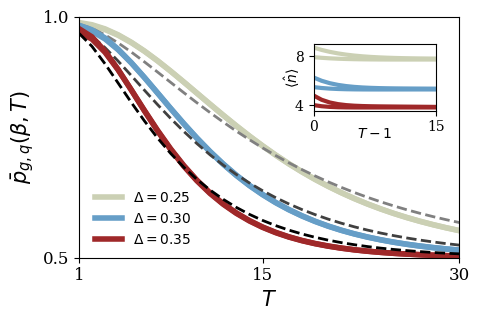

In [10]:
R0, R1 = 120,30
steps = 25
q0_range = (l/2)*np.linspace(0,1.0,steps)
p0_range = (l/8)*np.arange(0,9,1)
fit_params = []
R_range = np.arange(0,R1+1,1)

fig, ax = plt.subplots(figsize=(4.9,3.3))
inset_ax = fig.add_axes([0.65, 0.65, 0.25, 0.2])  # [left, bottom, width, height]
Delta_range = [.25,0.3,.35]

name = 'Paper-fig2-data-probabilities'
name_photons = 'Paper-fig2-data-photons'
data_all = np.load(path_QS_figures_data+name+'.npy',allow_pickle=True)
data_photons_all = np.load(path_QS_figures_data+name_photons+'.npy',allow_pickle=True)

for i in range(3):
    Delta = Delta_range[i]
    data = data_all[i]
    data_n = data_photons_all[i]
    j = int(steps/2)
    q0 = q0_range[j]
    markers = {0:'none',2:'none',4:'none'}
    colors = {0:lighten_color(green,.5),1:lighten_color(blue,.65),2:lighten_color(red,1)}
    for k in [0,4]:
        probs_q0_p0_q = data[j][k][0]
        probs_q0_p0_p = data[j][k][1]
        photons = data_n[j][k]
        sd, cd, td = np.sinh(Delta**2), np.cosh(Delta**2), np.tanh(Delta**2)
        # ax1.plot(R_range,probs_q0_p0_p,color=red,ls='-',lw=6)
        if k==0:
            ax.plot(R_range,probs_q0_p0_q,color=colors[i],ls='-',lw=4,label=r'$\Delta = {0:.2f}$'.format(Delta))
        else:
            ax.plot(R_range,probs_q0_p0_q,color=colors[i],ls='-',lw=4)
        inset_ax.plot(R_range,photons,color=colors[i],ls='-',lw=3)
        ax.set_ylim(.5,1)
        ax.set_xlim(1,R1)
        inset_ax.set_xlim(0,14)
        # inset_ax.set_ylim(5.25,5.75)
    def probability_function(T,b):
        a = 0.4
        return (1+np.exp(-a*Delta**2)*np.sin(l*cd*q0*np.exp(-b*Delta**2*T)))/2
    popt, pcov = curve_fit(probability_function, R_range, probs_q0_p0_q)
    print(popt,pcov)
    ax.plot(R_range,probability_function(R_range,*popt),ls='--',lw=2,color=lighten_color('black',.5+.25*i))

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']  # or ['STIXGeneral']

ax.tick_params(axis='both', which='major', labelsize=12)
inset_ax.tick_params(axis='both', which='major', labelsize=10)
ax.set_yticks([.5,1])
inset_ax.set_yticks([8,4])
ax.set_xlabel(r'$T$',fontsize=15)
ax.set_ylabel(r'$\bar p_{g,q}(\beta, T)$',fontsize=15)
inset_ax.set_xlabel(r'$T-1$',fontsize=10,labelpad=-5)
inset_ax.set_ylabel(r'$\langle \hat n\rangle$',fontsize=10,labelpad=-5)
inset_ax.set_xticks([0,15])
ax.set_xticks([1,15,30])
ax.legend(fontsize=10,frameon=False,bbox_to_anchor=(.33,.33))
plt.tight_layout()
plt.savefig(path_QS_figures+'Paper-fig2.pdf',bbox_inches='tight',dpi=600)
plt.show()


# Figure 3

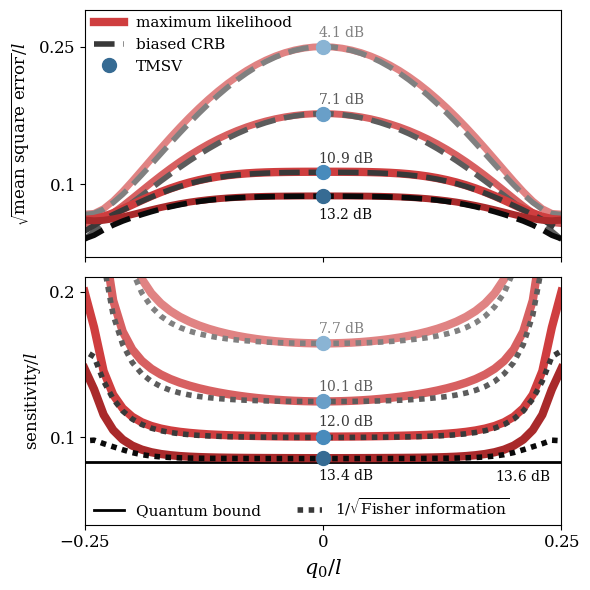

In [17]:
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['DejaVu Serif'],
    'mathtext.fontset': 'dejavuserif'
})
Delta = .3
cd = np.cosh(Delta**2)
fig, axs = plt.subplots(2,1,figsize=(6,6),sharex=True)
ax1, ax2 = axs
R1, k, steps, l = 10, 0, 51, np.sqrt(2*np.pi)
q0_range = (l/4)*np.linspace(-1.0,1.0,steps)
T_range = [1,2,4,10]

name = 'sensor_Delta={0:.2f}_R={1:.0f}.npz'.format(Delta,120)
sensor = sps.load_npz(path_QS_noiseless_states+name)
n = (n_op@sensor).diagonal().sum()
QFI = np.real(1/(4*n+2))

ax2.plot([-1,1],[np.sqrt(QFI)/l,np.sqrt(QFI)/l],color=lighten_color('black',1),lw=2,ls='-',label=r'Quantum bound')
ax.plot([-1,1],[np.sqrt(QFI)/l,np.sqrt(QFI)/l],color=lighten_color('black',1),lw=2,ls='-',label=None)

r_QFI = np.log(1/np.sqrt(QFI))
dB_QFI = 10*np.log10(np.exp(2*r_QFI))
gain_QFI = np.cosh(r_QFI)**2
ax2.text(0.18,.07,r'${0:.1f}$ dB'.format(dB_QFI),fontsize=10,color=lighten_color('black',1))

name = 'Paper-Fig3-data'
with open(path_QS_figures_data+name+'.pkl', 'rb') as file:
    data_all = pickle.load(file)

for i in range(4):
    T = T_range[i]
    dictionary = data_all[i]
    MSE = dictionary['MSE']
    biases = dictionary['biases']
    partial_means = dictionary['partial_means']
    FIqT = dictionary['FIqT']

    shine = .5+.2*np.log(T)

    if T==4:
        ax1.plot(q0_range/l,np.sqrt(MSE)/l,ls='-',color=lighten_color(red,shine),lw=6,label='maximum likelihood')
        ax1.plot(q0_range/l, np.sqrt(partial_means**2/FIqT)/l,color=lighten_color('black',shine),lw=4,ls='--',label='biased CRB')
    else:
        ax1.plot(q0_range/l,np.sqrt(MSE)/l,ls='-',color=lighten_color(red,shine),lw=5)
        ax1.plot(q0_range/l, np.sqrt(partial_means**2/FIqT)/l,color=lighten_color('black',shine),lw=4,ls='--')

    sensitivity = np.sqrt(MSE/partial_means**2)
    if T==4:
        ax2.plot(q0_range/l, sensitivity/l,color=lighten_color(red,shine),lw=6)
        ax2.plot(q0_range/l, np.sqrt(1/FIqT)/l,color=lighten_color('black',shine),lw=4,ls=(1,(1,1)),label=r'1/$\sqrt{\text{Fisher information}}$')
    else:
        ax2.plot(q0_range/l, sensitivity/l,color=lighten_color(red,shine),lw=6)
        ax2.plot(q0_range/l, np.sqrt(1/FIqT)/l,color=lighten_color('black',shine),lw=4,ls=(1,(1,1)))


    r = np.log(1/np.sqrt(MSE[int(steps/2)]))
    ind_mean = np.argmin((MSE[:int(steps/2)]-np.mean(MSE))**2)
    ind_max = int(steps/2)
    dB = 10*np.log10(np.exp(2*r))
    gain = np.cosh(r)**2
    rs = np.log(1/np.min(sensitivity))
    gains = np.cosh(rs)**2
    dBs = 10*np.log10(np.exp(2*rs))
    rmin = np.log(1/np.sqrt(np.min(MSE)))

    x0, y0 = -.005, .01

    if T==10:
        ax1.text(q0_range[ind_max]/l+x0,np.sqrt(MSE[ind_max])/l-.025,r'${0:.1f}$ dB'.format(dB),fontsize=10,color=lighten_color('black',shine))
        ax1.plot(q0_range[ind_max]/l,np.sqrt(MSE[ind_max])/l,'o',color=lighten_color(blue,shine),markersize=10,label='TMSV')
        ax2.text(q0_range[np.argmin(sensitivity)]/l+x0,sensitivity[np.argmin(sensitivity)]/l-.015,r'${0:.1f}$ dB'.format(dBs),fontsize=10,color=lighten_color('black',shine))
        ax2.plot(q0_range[np.argmin(sensitivity)]/l,sensitivity[np.argmin(sensitivity)]/l,'o',color=lighten_color(blue,shine),markersize=10)

    else:
        ax1.text(q0_range[ind_max]/l+x0,np.sqrt(MSE[ind_max])/l+.01,r'${0:.1f}$ dB'.format(dB),fontsize=10,color=lighten_color('black',shine))
        ax1.plot(q0_range[ind_max]/l,np.sqrt(MSE[ind_max])/l,'o',color=lighten_color(blue,shine),markersize=10)
        ax2.text(q0_range[np.argmin(sensitivity)]/l+x0,sensitivity[np.argmin(sensitivity)]/l+.007,r'${0:.1f}$ dB'.format(dBs),fontsize=10,color=lighten_color('black',shine))
        ax2.plot(q0_range[np.argmin(sensitivity)]/l,sensitivity[np.argmin(sensitivity)]/l,'o',color=lighten_color(blue,shine),markersize=10)


ax1.set_ylim(.02,.29)
ax1.set_xlim(-.25,.25)
ax2.set_ylim(0.04,.21)
ax2.set_xlim(-.25,.25)
xticks = [-1/4,0,1/4]
xlabels = [r'$-0.25$',r'$0$',r'$0.25$']
ax2.set_xticks(xticks)
ax2.set_xticklabels(xlabels,fontsize=12)
ax2.set_xlabel(r'$q_0/l$',fontsize=15)
y1ticks = [.1,.25]
y1labels = [r'$0.1$',r'$0.25$']
ax1.set_yticks(y1ticks)
ax1.set_yticklabels(y1labels,fontsize=12)
y2ticks = [.1,.2]
y2labels = [r'$0.1$',r'$0.2$']
ax2.set_yticks(y2ticks)
ax2.set_yticklabels(y2labels,fontsize=12)
ax1.set_ylabel(r'$\sqrt{\text{mean square error}}/l$',fontsize=12)
ax2.set_ylabel(r'$\text{sensitivity}/l$',fontsize=12)
ax1.legend(fontsize=11,loc='upper left',framealpha=0,bbox_to_anchor=(-0.01,1.03))
ax2.legend(fontsize=11,loc='lower left',framealpha=0,bbox_to_anchor=(-0.01,-0.03),ncol=2)

plt.tight_layout()
name = 'Paper-Fig3-ML-MSE-sensitivity'
plt.savefig(path_QS_figures+name+'.pdf',bbox_inches='tight',dpi=1000)

# Figure 4

In [18]:
def pg_q0(q0):
    return (1/2) * (1 + np.sin(l * q0))

def prob_ideal_bit(bit,q0):
    prob = 1
    for b in bit:
        if b == '0':
            prob *= pg_q0(q0)
        else:
            prob *= (1-pg_q0(q0))
    return prob

def MSE_onlyqorp(p_array: list, vlist: list, variance: float = 1, r: int = 1):

    def p_gaussian_prior(v: list, variance: float = 1):
        p_v = (1.0 / (np.sqrt(2 * np.pi) * variance)) * np.exp(
            -(1 / (2 * variance)) * v ** 2
        )
        return p_v / sum(p_v)

    p_array = np.transpose(p_array)
    estimator_arr = np.empty((2 ** (r)))
    posterior_arr = np.empty((2 ** (r), len(vlist)))

    for idx in range(2 ** (r)):
        p_y = sum(p_array[:, idx] * p_gaussian_prior(vlist, variance))  #gaussian prior
        posterior = p_array[:, idx] * p_gaussian_prior(vlist, variance) / p_y #gaussian posterior
        posterior_arr[idx, :] = posterior
        estimator_arr[idx] = sum(vlist * posterior)

    MSD_v_ = np.sum(
        p_array
        * (
            np.ones((len(vlist), 2 ** (r))) * estimator_arr
            - (vlist * np.ones((2 ** (r), len(vlist)))).T
        )
        ** 2,
        axis=1,
    )
    MSD = np.sum(p_gaussian_prior(vlist, variance) * np.array(MSD_v_))
    return MSD

def MSE_ideal_r(r, variance_list):
    MSE_ideal = []
    for variance in variance_list:
        q0_range = np.linspace(-l,l,101)
        probs_ideal_bit = []
        for i in range(2**r):
            bit = int_to_r_bits(i,r)
            probs = prob_ideal_bit(bit,q0_range)
            probs_ideal_bit.append(probs)
        probs_ideal_bit = np.array(probs_ideal_bit)
        MSE_ideal.append(MSE_onlyqorp(probs_ideal_bit, q0_range, variance, r))
    return MSE_ideal

stddev_range = np.arange(0.05,l/4+.1,.01)
variance = (0.15*l)**2
r = 4
MSE_ideal = MSE_ideal_r(r, [variance])
print(MSE_ideal/variance)

def analytical_1(v):
    return v*(1-l**2*v*np.exp(-l**2*v))
def analytical_2(v):
    a = l**2*v
    return v*(1-2*a/(np.cosh(a)+2*np.sinh(a)))

print(analytical_1(variance)/variance)
print(analytical_2(variance)/variance)

[0.34687107]
0.6345954682858064
0.4836686452910889


/var/folders/vk/yq14ng8x7rd4q_4cz8t84tj80000gq/T/ipykernel_87510/433133045.py:146: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  ax.legend(handles, labels,loc='upper right',fontsize=9,frameon=True,ncol=2)


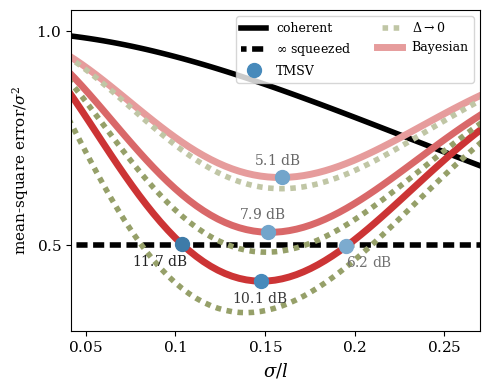

In [22]:
def coherent_limit(v):
    return 1/(v+1)
def gaussian_limit(v):
    return v/2/v

def two_mode_squeezing_limit(v,r):
    return np.exp(-2*r)*v/(np.exp(-2*r)+v)
from scipy.optimize import fsolve
def solve_for_r(v, MSE):
    # Define the equation to solve
    def equation(r):
        return two_mode_squeezing_limit(v, r) - MSE
    # Use fsolve to find the root of the equation
    r_initial_guess = 0.5 # Initial guess for r
    r_solution = fsolve(equation, r_initial_guess)
    return r_solution[0]

def solve_for_r_coherent(v,MSE):
    # Define the equation to solve
    def equation(r):
        return coherent_limit(v, r) - MSE
    # Use fsolve to find the root of the equation
    r_initial_guess = 0.5 # Initial guess for r
    r_solution = fsolve(equation, r_initial_guess)
    return r_solution[0]

def minimum_r(stddev_range,MSE_array):
    r_array = np.zeros(len(MSE_array))
    for i in range(len(MSE_array)):
        MSE = MSE_array[i]
        v = stddev_range[i]
        r = solve_for_r(v, MSE)
        r_array[i] = r
    return r_array

def analytical_1(v):
    return v*(1-l**2*v*np.exp(-l**2*v))
def analytical_2(v):
    a = l**2*v
    return v*(1-2*a/(np.cosh(a)+2*np.sinh(a)))

Delta, k, steps, R = 0.3,0,51,4
cd = np.cosh(Delta**2)
q0_range = (l)*np.linspace(-1.0,1.0,steps)
stddev_range = np.arange(0.05,l/4+.1,.01)

fig, ax = plt.subplots(1,1,figsize=(5,4))

line1, = ax.plot(stddev_range, coherent_limit(stddev_range**2),color='black',ls='-',lw=4,label='coherent')
line2, = ax.plot(stddev_range, gaussian_limit(stddev_range**2),color='black',ls=(1,(2,1)),lw=4,label=r'$\infty$ squeezed')
lines = [line1,line2]

name = 'Paper-Fig4-data'
with open(path_QS_figures_data+name+'.pkl', 'rb') as f:
    data_all = pickle.load(f)

T_range = [4,2,1]
for i in range(3):
    T = T_range[i]
    dictionary = data_all[i]
    MSE = dictionary['MSEs']
    MSE_q = dictionary['mse_qrange']
    data_all.append(dictionary)
    
    shine = .4+.3*np.log(T)
    if i==2:
        line3, = ax.plot(stddev_range,MSE/stddev_range**2,color=lighten_color(red,shine),lw=5,label='Bayesian')
    else:
        line3, = ax.plot(stddev_range,MSE/stddev_range**2,color=lighten_color(red,shine),lw=5)

    variance_list = stddev_range**2
    r_array = minimum_r(variance_list,MSE)
    r_max, argmax = np.max(r_array), np.argmax(r_array)

    ind = np.argmin(np.abs(MSE)/variance_list)
    index_gaussian = np.argmin(np.abs(MSE[ind:]/variance_list[ind:] - 0.5))

    ind_min = 12
    r_min = solve_for_r(variance_list[ind_min], variance_list[ind_min]/2)
    db_min = 10*np.log10(np.exp(2*r_min))
    
    if i==0:
        index_gaussian = np.argmin(np.abs(MSE[ind:]/variance_list[ind:] - 0.5))
        index_gaussian2 = np.argmin(np.abs(MSE[:ind]/variance_list[:ind] - 0.5))
    else:
        pass

    if i==0:
        r = solve_for_r(variance_list[ind], MSE[ind])
        dB = 10*np.log10(np.exp(2*r))
        gain = np.cosh(r)**2
        rg1 = solve_for_r(variance_list[ind+index_gaussian], MSE[ind+index_gaussian])
        dbg1 = 10*np.log10(np.exp(2*rg1))
        rg2 = solve_for_r(variance_list[index_gaussian2], MSE[index_gaussian2])
        dbg2 = 10*np.log10(np.exp(2*rg2))
        rmin = solve_for_r(variance_list[ind_min], MSE[ind_min])
        dBmin = 10*np.log10(np.exp(2*rmin))
        ax.text(np.sqrt(variance_list[ind])-.04,MSE[ind]/variance_list[ind]-.05,r'${0:.1f}$ dB'.format(dB),fontsize=10,color=lighten_color('black',.2+r/2))
        line4, = ax.plot(np.sqrt(variance_list[ind]),MSE[ind]/variance_list[ind],'o',color=lighten_color(blue,.2+r/2),markersize=10,label='TMSV')
        lines.append(line4)
        ax.text(np.sqrt(variance_list[ind+index_gaussian])+.0,MSE[ind+index_gaussian]/variance_list[ind+index_gaussian]-.05,r'${0:.1f}$ dB'.format(dbg1),fontsize=10,color=lighten_color('black',.2+rg1/2))
        ax.plot(np.sqrt(variance_list[ind+index_gaussian]),MSE[ind+index_gaussian]/variance_list[ind+index_gaussian],'o',color=lighten_color(blue,.2+rg1/2),markersize=10,label=None)
        ax.text(np.sqrt(variance_list[index_gaussian2])-.07,MSE[index_gaussian2]/variance_list[index_gaussian2]-.05,r'${0:.1f}$ dB'.format(dbg2),fontsize=10,color=lighten_color('black',.2+rg2/2))
        ax.plot(np.sqrt(variance_list[index_gaussian2]),MSE[index_gaussian2]/variance_list[index_gaussian2],'o',color=lighten_color(blue,.2+rg2/2),markersize=10,label=None)
        # ax.text(np.sqrt(variance_list[ind_min])-.06,MSE[ind_min]/variance_list[ind_min]-.04,r'${0:.1f}$ dB'.format(dBmin),fontsize=13,color=lighten_color('black',1))
        # ax.plot(np.sqrt(variance_list[ind_min]),MSE[ind_min]/variance_list[ind_min],'o',color=lighten_color('black',1),markersize=10,label=None)
    elif i==1 or i==2:
        r = solve_for_r(variance_list[ind], MSE[ind])
        dB = 10*np.log10(np.exp(2*r))
        gain = np.cosh(r)**2
        rg2 = solve_for_r(variance_list[index_gaussian2], MSE[index_gaussian2])
        dbg2 = 10*np.log10(np.exp(2*rg2))
        rmin = solve_for_r(variance_list[ind_min], MSE[ind_min])
        dBmin = 10*np.log10(np.exp(2*rmin))
        ax.text(np.sqrt(variance_list[ind])-.04,MSE[ind]/variance_list[ind]+.03,r'${0:.1f}$ dB'.format(dB),fontsize=10,color=lighten_color('black',1-.4))
        ax.plot(np.sqrt(variance_list[ind]),MSE[ind]/variance_list[ind],'o',color=lighten_color(blue,1-.4),markersize=10)
        # ax.text(np.sqrt(variance_list[index_gaussian2])+0.01,MSE[index_gaussian2]/variance_list[index_gaussian2]-.01,r'${0:.1f}$ dB'.format(dbg2),fontsize=13,color=lighten_color('black',1-.2))
        # ax.plot(np.sqrt(variance_list[index_gaussian2]),MSE[index_gaussian2]/variance_list[index_gaussian2],'o',color=lighten_color('black',1-.2),markersize=10,label=None)
        # ax.text(np.sqrt(variance_list[ind_min])-.0,MSE[ind_min]/variance_list[ind_min]+.015,r'${0:.1f}$ dB'.format(dBmin),fontsize=13,color=lighten_color('black',1))
        # ax.plot(np.sqrt(variance_list[ind_min]),MSE[ind_min]/variance_list[ind_min],'o',color=lighten_color('black',1),markersize=10,label=None)
    if i==2:
        line5, = ax.plot(stddev_range,analytical_1(variance_list)/variance_list,color=lighten_color(green,.6),ls=(1,(1,1)),lw=4,label=r'$\Delta\to 0$')
        lines.append(line5)
    elif i==1:
        ax.plot(stddev_range,analytical_2(variance_list)/variance_list,color=lighten_color(green,1),ls=(1,(1,1)),lw=4)
    elif i==0:
        ax.plot(stddev_range,MSE_ideal_r(4,variance_list)/variance_list,color=lighten_color(green,1),ls=(1,(1,1)),lw=4)
    lines.append(line3)



handles = lines
labels = [h.get_label() for h in handles]

l = np.sqrt(2*np.pi)
ax.set_xlim(0.042*l,0.27*l)
ax.set_ylim(.3,1.05)
ax.set_xlabel(r'$\sigma/l$',fontsize=13)
ax.set_xticks([0.05*l,0.1*l,0.15*l,0.2*l,0.25*l])
ax.set_yticks([0.5,1])
xlabels = [r'$0.05$',r'$0.1$',r'$0.15$',r'$0.2$',r'$0.25$']
ylabels = [r'$0.5$',r'$1.0$']
ax.set_xticklabels(xlabels,fontsize=11)
ax.set_yticklabels(ylabels,fontsize=11)
ax.set_ylabel(r'$\text{mean-square error}/\sigma^2$',fontsize=11)
ax.legend(handles, labels,loc='upper right',fontsize=9,frameon=True,ncol=2)

plt.tight_layout()
name = 'Paper-Fig4-bayesian'
plt.savefig(path_QS_figures+name+'.pdf',format='pdf',bbox_inches='tight',dpi=1000)
plt.show()

# Figure 5

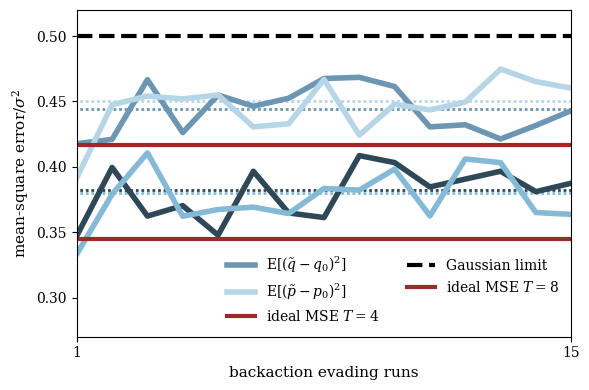

In [28]:
Delta = 0.3
k = 0
T = 8
M_range = [4,8]
stddev_range = np.arange(0.05,l/4+.1,.01)
sigma = stddev_range[np.argmin(np.abs(stddev_range-0.15*l))]
index_sigma = np.argmin(np.abs(stddev_range-sigma))
runs = 4000
repeat_baem = 15
steps = 51

fig, ax = plt.subplots(1,1,figsize=(6,4))
x_range = np.arange(1,repeat_baem+1,1)

name = 'data-figure5-BA-performance'
dict_figure = np.load(path_QS_figures_data+name+'.npz',allow_pickle=True)

mean_MSE_q_Trange = dict_figure['mean_MSE_q_Trange']
mean_MSE_p_Trange = dict_figure['mean_MSE_p_Trange']
mean_means_MSE_q_Trange = dict_figure['mean_means_MSE_q_Trange']
mean_means_MSE_p_Trange = dict_figure['mean_means_MSE_p_Trange']
ideal_MSE_Trange = dict_figure['ideal_MSE_Trange']
T_range = dict_figure['T_range']
for i in range(len(T_range)):
    T = T_range[i]

    mean_MSE_q = mean_MSE_q_Trange[i]
    mean_MSE_p = mean_MSE_p_Trange[i]
    mean_means_MSE_q = mean_means_MSE_q_Trange[i]
    mean_means_MSE_p = mean_means_MSE_p_Trange[i]
    min_MSE = ideal_MSE_Trange[i]

    shine = .6+.4*i
    ax.plot(x_range,mean_means_MSE_q_Trange[i]*np.ones(len(x_range)),color=lighten_color(dark_blue,shine),lw=2,label=None,ls=(1,(1,1)))
    ax.plot(x_range,mean_means_MSE_p_Trange[i]*np.ones(len(x_range)),color=lighten_color(light_blue,shine),lw=2,label=None,ls=(1,(1,1)))

    if i ==0:
        ax.plot(x_range,mean_MSE_q/sigma**2,color=lighten_color(dark_blue,shine),lw=4,label=r'E$[(\tilde q-q_0)^2]$')
        ax.plot(x_range,mean_MSE_p/sigma**2,color=lighten_color(light_blue,shine),lw=4,label=r'E$[(\tilde p-p_0)^2]$')
        ax.plot(x_range,min_MSE*np.ones(len(x_range)),color=lighten_color(red,1),lw=3,label=r'ideal MSE $T={0:.0f}$'.format(T))
        ax.plot([1,31],[.5,.5],color='black',ls='--',lw=3,label=r'Gaussian limit')
    else:
        ax.plot(x_range,mean_MSE_q/sigma**2,color=lighten_color(dark_blue,shine),lw=4,label=None)
        ax.plot(x_range,mean_MSE_p/sigma**2,color=lighten_color(light_blue,shine),lw=4,label=None)
        ax.plot(x_range,min_MSE*np.ones(len(x_range)),color=lighten_color(red,1),lw=3,label=r'ideal MSE $T={0:.0f}$'.format(T))


# dict_fig_5['MSE_Mrange'] = MSE_Mrange
# dict_fig_5['MSE_q_Mrange'] = MSE_q_Mrange
# dict_fig_5['results_Mrange'] = results_Mrange    

ax.set_xticks([1,15,30])
ax.set_yticks([.3,.35,.4,.45,.5])
ax.set_xlabel(r'backaction evading runs',fontsize=11)
ax.set_ylabel(r'mean-square error$/\sigma^2$',fontsize=11)

ax.set_ylim(0.27,.52)
ax.set_xlim(1,15)
ax.legend(loc='lower right',fontsize=10,ncol=2,framealpha=0)
plt.tight_layout()
name = 'Paper-Fig5-backaction_evading_MSE'
fig.savefig(path_QS_figures+name+'.pdf',bbox_inches='tight',dpi=1000)
plt.show()

## old version

In [ ]:
# Delta = 0.3
# k = 0
# T = 8
# M_range = [4,8]
# stddev_range = np.arange(0.05,l/4+.1,.01)
# sigma = stddev_range[np.argmin(np.abs(stddev_range-0.15*l))]
# index_sigma = np.argmin(np.abs(stddev_range-sigma))
# runs = 4000
# repeat_baem = 15 # N
# steps = 51

# fig, ax = plt.subplots(1,1,figsize=(6,4))
# x_range = np.arange(1,repeat_baem+1,1)

# name = 'Paper-Fig5-data'
# with open(path_QS_figures_data+name+'.pkl', 'rb') as f:
#     dict_fig_5 = pickle.load(f)

# # dict_fig_5 = {}
# # MSE_Mrange = []
# # MSE_q_Mrange = []
# # results_Mrange = []

# MSE_Mrange =  dict_fig_5['MSE_Mrange']
# MSE_q_Mrange = dict_fig_5['MSE_q_Mrange']
# results_Mrange = dict_fig_5['results_Mrange']

# for i in range(len(M_range)):
#     M = M_range[i]

#     # name = 'backaction_evading_bayesian_Delta={0:.2f}_T={1:.0f}_M={2:.0f}_sigma={3:.2f}_runs={4:.0f}_repeats={5:.0f}'.format(Delta,T,M,sigma/l,runs,repeat_baem)
#     # result = np.load(path_sBs_MP_BA+name+'.npy',allow_pickle=True)
#     # results_Mrange.append(result)
#     result = results_Mrange[i]

#     # name = 'gaussian_prior_fullqmap_Delta={0:.2f}_T={1:.0f}_p0=lover{2:.0f}_q0range(-l,l)_steps={3:.0f}'.format(Delta,T,k,steps)
#     # with open(path_sBs_bayesian+name+'.pkl', 'rb') as f:
#     #     dictionary = pickle.load(f)
#     # MSE = dictionary['MSEs']
#     # MSE_q = dictionary['mse_qrange']
#     # MSE_Mrange.append(MSE)
#     # MSE_q_Mrange.append(MSE_q)
#     MSE = MSE_Mrange[i]
#     MSE_q = MSE_q_Mrange[i]

#     min_MSE = np.min(MSE/stddev_range**2)

#     squared_errors_q = result[:,0,:]
#     squared_errors_p = result[:,1,:]
#     mean_MSE_q = np.mean(squared_errors_q,axis=0)
#     mean_MSE_p = np.mean(squared_errors_p,axis=0)

#     mean_means_MSE_q = np.mean(mean_MSE_q[1:])/sigma**2
#     mean_means_MSE_p = np.mean(mean_MSE_p[1:])/sigma**2
#     stddev_means_MSE_q = np.std(mean_MSE_q[1:])/sigma**2
#     stddev_means_MSE_p = np.std(mean_MSE_p[1:])/sigma**2

#     print(mean_means_MSE_q,mean_means_MSE_p)

#     shine = .6+.4*i
#     ax.plot(x_range,mean_means_MSE_q*np.ones(len(x_range)),color=lighten_color(dark_blue,shine),lw=2,label=None,ls=(1,(1,1)))
#     ax.plot(x_range,mean_means_MSE_p*np.ones(len(x_range)),color=lighten_color(light_blue,shine),lw=2,label=None,ls=(1,(1,1)))
    
    
#     if i ==0:
#         ax.plot(x_range,mean_MSE_q/sigma**2,color=lighten_color(dark_blue,shine),lw=4,label=r'E$[(\tilde q-q_0)^2]$')
#         ax.plot(x_range,mean_MSE_p/sigma**2,color=lighten_color(light_blue,shine),lw=4,label=r'E$[(\tilde p-p_0)^2]$')
#         ax.plot(x_range,min_MSE*np.ones(len(x_range)),color=lighten_color(red,1),lw=3,label=r'ideal MSE $T=8$')
#         ax.plot([1,31],[.5,.5],color='black',ls='--',lw=3,label=r'Gaussian limit')
#     else:
#         ax.plot(x_range,mean_MSE_q/sigma**2,color=lighten_color(dark_blue,shine),lw=4,label=None)
#         ax.plot(x_range,mean_MSE_p/sigma**2,color=lighten_color(light_blue,shine),lw=4,label=None)
    
#     # Add shadow for the red line
#     ax.fill_between(x_range, (mean_means_MSE_q - stddev_means_MSE_q) * np.ones(len(x_range)),
#                     (mean_means_MSE_q + stddev_means_MSE_q) * np.ones(len(x_range)),
#                     color=lighten_color(dark_blue, shine-.1), alpha=.1)

#     # Add shadow for the blue line
#     ax.fill_between(x_range, (mean_means_MSE_p - stddev_means_MSE_p) * np.ones(len(x_range)),
#                     (mean_means_MSE_p + stddev_means_MSE_p) * np.ones(len(x_range)),
#                     color=lighten_color(light_blue, shine-.1), alpha=0.25)


# # dict_fig_5['MSE_Mrange'] = MSE_Mrange
# # dict_fig_5['MSE_q_Mrange'] = MSE_q_Mrange
# # dict_fig_5['results_Mrange'] = results_Mrange    

# ax.set_xticks([1,15,30])
# ax.set_yticks([.3,.35,.4,.45,.5])
# ax.set_xlabel(r'backaction evading runs',fontsize=11)
# ax.set_ylabel(r'mean-square error$/\sigma^2$',fontsize=11)

# ax.set_ylim(0.27,.52)
# ax.set_xlim(1,15)
# ax.legend(loc='lower right',fontsize=10,ncol=2,framealpha=0)
# plt.tight_layout()
# name = 'backaction_evading_MSE'
# fig.savefig(path_figures+name+'.pdf',bbox_inches='tight',dpi=1000)
# plt.show()

# Figure 6

### load sensitivity

In [8]:
#definitions of the parameters (q bits)
#116-119, delta = 0.3,  yale, 1, 2, 4, 8 rounds, p0=0, sensitivity
#120-123, delta = 0.3, 0.5 yale, 1, 2, 4, 8 rounds, sensitivity
#124-127, delta = 0.3, 0.75 yale, 1, 2, 4, 8 rounds, sensitivity
#128-131, delta = 0.3, 1.5 yale, 1, 2, 4, 8 rounds, sensitivity
#132-135, delta = 0.3, 0.25 yale, 1, 2, 4, 8 rounds, sensitivity
#147-150, delta = 0.3, 2.0 yale, 1, 2, 4, 8 rounds, p0=0, sensitivity with p0=0
#158-161, delta = 0.3, 0.25 yale, 1,2,4,8 rounds, sensitivity

MSE_arrays = []
sensitivities = []
l = np.sqrt(2*np.pi)
vlist = np.linspace(-.25*l, .25*l, 60)
for idx in tqdm([150,119,123,161]):
    name = 'Data - qbits - params'+str(idx)
    results = np.load(path_QS_noise_results_qorppath+name+'.npz',allow_pickle=True)
    p_array = results['p_array']
    system_dict = results['system_dict'].item()
    r = system_dict["simulations"]["r"]
    MSE, biases, partials, variances = MSE_ML_q0_q_map(p_array, r, vlist, r, 60)
    sensitivity = np.sqrt(MSE/partials**2)
    MSE_arrays.append(MSE)
    sensitivities.append(sensitivity)

delta, T = .3,8
name = 'data-noiseless-sensitivity-fullqmap-delta={0:.2f}-T={1:.0f}'.format(delta,T)
with open(path_QS_noiseless_results+name+'.pkl', 'rb') as file:
    dictionary = pickle.load(file)

partial_means = dictionary['partial_means']
MSE = dictionary['MSE']
sensitivity_noiseless = np.sqrt(MSE/partial_means**2)


100%|██████████| 4/4 [00:13<00:00,  3.30s/it]


### load gaussian

In [4]:
#definitions of the parameters (q bits)
#1-3, delta = 0.3, yale, 1, 2, 8 rounds, p0=0
#4-6, delta = 0.3, yale, 1, 2, 8 rounds, p0=l/4
#7-9, delta = 0.3, yale, 1, 2, 8 rounds, q0=0
#10-12, delta = 0.3, yale, 1, 2, 8 rounds, q0=l/4
#13-14, delta = 0.3, yale, 4 rounds, q0=0, p0=0
#15-16, delta = 0.3, yale, 4 rounds, q0=l/4, p0=l/4
#17-19, delta = 0.3, 0.5 yale, 1,2,4 rounds, p0=l/4
#20-22, delta = 0.3, 0.5 yale, 1,2,4 rounds, q0=l/4
#23-24, delta = 0.3, 1.0, 0.5 yale, 8 rounds, p0=0
#25-27, delta = 0.25, yale, 1, 2, 4 rounds, p0=0
#28-30, delta = 0.25, 0.5 yale, 1, 2, 4 rounds, p0=0
#31-46, delta in (.25,.4,.01), yale, 1, round p0=0
#48-63, delta in (.25,.4,.01), 0.5 yale, 1, round p0=0
#64-79, delta in (.25,.4,.01), 0.75 yale, 1, round p0=0
#80-95, delta in (.25,.4,.01), 1.5 yale, 1, round p0=0
#96-99, delta = 0.34, yale, 1, 2, 4, 8 rounds, p0=0
#100-103, delta = 0.3, 0.75 yale, 1, 2, 4, 8 rounds, p0=0
#104-107, delta = 0.3, 1.5 yale, 1, 2, 4, 8 rounds, p0=0
#108-111, delta = 0.34, 0.75 yale, 1, 2, 4, 8 rounds, p0=0
#112-115, delta = 0.3, 1.5 yale, 1, 2, 4, 8 rounds, p0=0
#116-119, delta = 0.3,  yale, 1, 2, 4, 8 rounds, p0=0, sensitivity
#120-123, delta = 0.3, 0.5 yale, 1, 2, 4, 8 rounds, sensitivity
#124-127, delta = 0.3, 0.75 yale, 1, 2, 4, 8 rounds, sensitivity
#128-131, delta = 0.3, 1.5 yale, 1, 2, 4, 8 rounds, sensitivity
#132-135, delta = 0.3, 0.25 yale, 1, 2, 4, 8 rounds, sensitivity
#136-138, delta = 0.3, .5,1,1.5 yale, 4 rounds, sensitivity with p0=l/4
#139-142, delta = 0.3, 1 yale, 1,2,4,8 rounds, sensitivity with q0=0 p quadrature runs
#143-146, delta = 0.3, 2.0 yale, 1, 2, 4, 8 rounds, 
#147-150, delta = 0.3, 2.0 yale, 1, 2, 4, 8 rounds, sensitivity with p0=0
#151-152, delta = 0.3, 1.0 yale, 8 rounds, p0=0, q0=0 #use these results for backaction evading inputs
#153, delta = 0.3, 1.0 yale, 2 rounds, q0 = 0
#154-157, delta = 0.3, 0.25 yale, 1,2,4,8 rounds, p0 = 0
#158-161, delta = 0.3, 0.25 yale, 1,2,4,8 rounds, sensitivity

MSE_arrays_30 = []

for idx in [146,151,24, 157]:
    name = 'Data - qbits - params'+str(idx)
    results = np.load(path_QS_noise_results_qorppath+name+'.npz')
    variance_list = results['variance_list']
    vlist = results['vlist']
    MSE = np.sum(results['MSD_array'], axis=1)
    MSE_arrays_30.append(MSE)

def coherent_limit(v):
    return 1/(v+1)
def gaussian_limit(v):
    return v/2/v

def two_mode_squeezing_limit(v,r):
    return np.exp(-2*r)*v/(np.exp(-2*r)+v)
from scipy.optimize import fsolve
def solve_for_r(v, MSE):
    # Define the equation to solve
    def equation(r):
        return two_mode_squeezing_limit(v, r) - MSE
    # Use fsolve to find the root of the equation
    r_initial_guess = 0.5 # Initial guess for r
    r_solution = fsolve(equation, r_initial_guess)
    return r_solution[0]

def solve_for_r_coherent(v,MSE):
    # Define the equation to solve
    def equation(r):
        return coherent_limit(v, r) - MSE
    # Use fsolve to find the root of the equation
    r_initial_guess = 0.5 # Initial guess for r
    r_solution = fsolve(equation, r_initial_guess)
    return r_solution[0]

def minimum_r(stddev_range,MSE_array):
    r_array = np.zeros(len(MSE_array))
    for i in range(len(MSE_array)):
        MSE = MSE_array[i]
        v = stddev_range[i]
        r = solve_for_r(v, MSE)
        r_array[i] = r
    return r_array

def analytical_1(v):
    return v*(1-l**2*v*np.exp(-l**2*v))
def analytical_2(v):
    a = l**2*v
    return v*(1-2*a/(np.cosh(a)+2*np.sinh(a)))

### plot

0 12.319249816805474
1 11.585647944116973
2 10.327404885856474
3 8.286336712865225
(101,)
min MSE 0 0.3935349908235049 0.8813767280760513
(101,)
min MSE 1 0.4405244179992984 0.8877165651863296
(101,)
min MSE 2 0.5269295050708518 0.9030362618093183


/var/folders/vk/yq14ng8x7rd4q_4cz8t84tj80000gq/T/ipykernel_87510/4050852241.py:56: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(fontsize=11,loc='lower left',framealpha=0,bbox_to_anchor=(-0.01,-0.03),ncol=2)


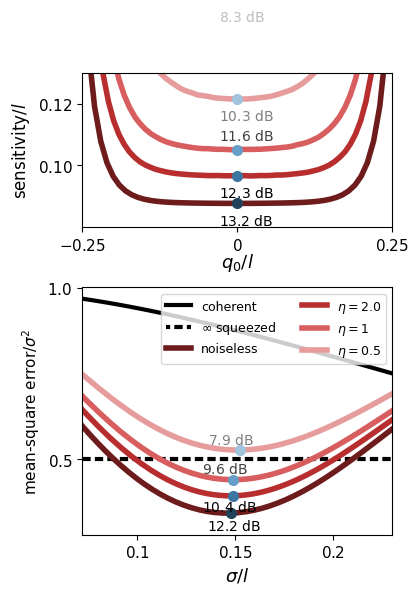

In [5]:
fig, axs = plt.subplots(2, 1, figsize=(4, 6),gridspec_kw={'height_ratios': [1, 1.6]})
plt.subplots_adjust(hspace=0.3)  # Increase the value to add more space
ax1, ax2 = axs

steps1, steps2 = 60, 51
q0range1, q0range2 = np.linspace(-l/4,l/4,steps1), np.linspace(-l/4,l/4,steps2)

name = 'Paper-Fig6-data'
with open(path_QS_figures_data+name+'.pkl', 'rb') as f:
    dict_fig_6 = pickle.load(f)

sensitivity_noiseless = dict_fig_6['sensitivity_noiseless']
sensitivities = dict_fig_6['sensitivities']

# dict_fig_6 = {}
# dict_fig_6['sensitivity_noiseless'] = sensitivity_noiseless
# dict_fig_6['sensiti/vities'] = sensitivities

ax1.plot(q0range2/l, sensitivity_noiseless/l,color=lighten_color(red,1.2),lw=4, ls='-')
rs = np.log(1/np.min(sensitivity_noiseless))
gains = np.cosh(rs)**2
dBs = 10*np.log10(np.exp(2*rs))
x0, y0 = -.03, -.007
ax1.text(q0range2[25]/l+x0,sensitivity_noiseless[np.argmin(sensitivity_noiseless)]/l+y0,r'${0:.1f}$ dB'.format(dBs),fontsize=10,color=lighten_color('black',1.0))
ax1.plot(q0range2[25]/l,sensitivity_noiseless[np.argmin(sensitivity_noiseless)]/l,'o',color=lighten_color(blue,1.2),markersize=7)


for i in range(4):
    shine = .9-.25*i
    sensitivity = sensitivities[i]
    ax1.plot(q0range1/l, sensitivity/l,color=lighten_color(red,shine),lw=4)
    
    rs = np.log(1/np.min(sensitivity))
    gains = np.cosh(rs)**2
    dBs = 10*np.log10(np.exp(2*rs))
    print(i,dBs)
    if i==1:
        x0, y0 = -.03, .003
    else:
        x0, y0 = -.03, -.007
    ax1.text(q0range2[25]/l+x0,sensitivity[np.argmin(sensitivity)]/l+y0,r'${0:.1f}$ dB'.format(dBs),fontsize=10,color=lighten_color('black',shine+.1))
    ax1.plot(q0range2[25]/l,sensitivity[np.argmin(sensitivity)]/l,'o',color=lighten_color(blue,shine),markersize=7)
    
ax1.set_ylim(0.08,.13)
ax1.set_xlim(-.25,.25)
xticks = [-1/4,0,1/4]
xlabels = [r'$-0.25$',r'$0$',r'$0.25$']
ax1.set_xticks(xticks)
ax1.set_xticklabels(xlabels,fontsize=11)
ax1.set_xlabel(r'$q_0/l$',fontsize=13,labelpad=-1)
y1ticks = [.1,.12]
y1labels = [r'$0.10$',r'$0.12$']
ax1.set_yticks(y1ticks)
ax1.set_yticklabels(y1labels,fontsize=11)
ax1.set_ylabel(r'$\text{sensitivity}/l$',fontsize=12)
ax1.legend(fontsize=11,loc='lower left',framealpha=0,bbox_to_anchor=(-0.01,-0.03),ncol=2)


Delta, k, steps, R = 0.3,0,51,4
cd = np.cosh(Delta**2)
q0_range = (l)*np.linspace(-1.0,1.0,steps)
stddev_range = np.arange(0.05,l/4+.1,.01)

line1, = ax2.plot(stddev_range, coherent_limit(stddev_range**2),color='black',ls='-',lw=3,label='coherent')
line2, = ax2.plot(stddev_range, gaussian_limit(stddev_range**2),color='black',ls=(1,(2,1)),lw=3,label=r'$\infty$ squeezed')
lines = [line1,line2]

# name = 'gaussian_prior_fullqmap_Delta={0:.2f}_T={1:.0f}_p0=lover{2:.0f}_q0range(-l,l)_steps={3:.0f}'.format(Delta,T,k,steps)
# with open(path_QS_noiseless_results+name+'.pkl', 'rb') as f:
#     dictionary = pickle.load(f)
# MSE = dictionary['MSEs']
MSE = dict_fig_6['MSE_noiseless']
line3, = ax2.plot(stddev_range,MSE/stddev_range**2,color=lighten_color(red,1.2),lw=4, ls='-',label='noiseless')
lines.append(line3)
ind = np.argmin(np.abs(MSE)/stddev_range**2)    
r = solve_for_r(variance_list[ind], MSE[ind])
dB = 10*np.log10(np.exp(2*r))
gain = np.cosh(r)**2
x0, y0 = -.03, -.05
ax2.text(stddev_range[ind]+x0,MSE[ind]/stddev_range[ind]**2+y0,r'${0:.1f}$ dB'.format(dB),fontsize=10,color=lighten_color('black',1.0))
ax2.plot(stddev_range[ind],MSE[ind]/stddev_range[ind]**2,'o',color=lighten_color(blue,1.2),markersize=7)

# dict_fig_6['MSE_noiseless'] = MSE
# dict_fig_6['MSE'] = MSE_arrays_30
MSE_arrays_30 = dict_fig_6['MSE']


labels = [r'$\eta = 2.0$',r'$\eta = 1$',r'$\eta = 0.5$',r'$\eta = 0.25$']
for i in range(3):
    shine = .9-.25*i
    MSE = MSE_arrays_30[i]
    print(MSE.shape)
    line4, = ax2.plot(np.sqrt(variance_list), MSE/variance_list,lw=4,color=lighten_color(red,shine),label=labels[i])
    lines.append(line4)
    print('min MSE',i, np.min(MSE/variance_list), np.max(MSE/variance_list))
    ind = np.argmin(np.abs(MSE)/variance_list)    
    r = solve_for_r(variance_list[ind], MSE[ind])
    dB = 10*np.log10(np.exp(2*r))
    gain = np.cosh(r)**2

    if i==0:
        x0, y0 = -.04,-.045
    else:
        x0, y0 = -.04,.018
    ax2.text(np.sqrt(variance_list[ind])+x0,MSE[ind]/variance_list[ind]+y0,r'${0:.1f}$ dB'.format(dB),fontsize=10,color=lighten_color('black',shine+.1))
    ax2.plot(np.sqrt(variance_list[ind]),MSE[ind]/variance_list[ind],'o',color=lighten_color(blue,shine),markersize=7)

handles = lines
labels = [h.get_label() for h in handles]

l = np.sqrt(2*np.pi)
ax2.set_xlim(0.072*l,0.23*l)
ax2.set_ylim(.28,1.001)
ax2.set_xlabel(r'$\sigma/l$',fontsize=13)
ax2.set_xticks([0.1*l,0.15*l,0.2*l])
ax2.set_yticks([0.5,1])
xlabels = [r'$0.1$',r'$0.15$',r'$0.2$']
ylabels = [r'$0.5$',r'$1.0$']
ax2.set_xticklabels(xlabels,fontsize=11)
ax2.set_yticklabels(ylabels,fontsize=11)
ax2.set_ylabel(r'$\text{mean-square error}/\sigma^2$',fontsize=11)
ax2.legend(handles, labels,loc='upper right',fontsize=9,frameon=True,ncol=2)

name = 'Paper-Fig6'
fig.savefig(path_QS_figures+name+'.pdf',format='pdf',dpi=1000,bbox_inches='tight')
plt.show()

# dict_fig_6['sensitivities'] = sensitivities
# dict_fig_6['MSE'] = MSE_arrays_30

# name = 'Paper-Fig6-data'
# with open(path_QS_figures_data+name+'.pkl', 'wb') as f:
#     pickle.dump(dict_fig_6, f)


# Appendices 

## Noiseless

### probabilities sBs (Fig 7)

/Users/labl2714/Projects/GKP-metrology/LL_env_1/lib/python3.10/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/labl2714/Projects/GKP-metrology/LL_env_1/lib/python3.10/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


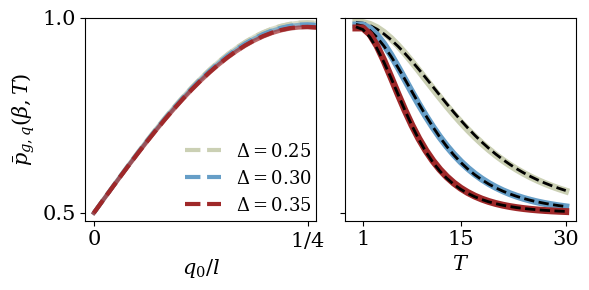

In [27]:
# dict_figure = {}
# dict_figure['probs_qrange'] = probs_qrange
# dict_figure['probs_Trange'] = probs_Trange
# dict_figure['fit_qrange'] = fit_qrange
# dict_figure['fit_Trange'] = fit_Trange
# dict_figure['Delta_range'] = Delta_range
# dict_figure['q0_range'] = q0_range
# dict_figure['Trange'] = R_range
name = 'data-Fig7'
dict_figure = np.load(path_QS_figures_data+name+'.npz',allow_pickle=True)
probs_qrange = dict_figure['probs_qrange']
probs_Trange = dict_figure['probs_Trange']
fit_qrange = dict_figure['fit_qrange']
fit_Trange = dict_figure['fit_Trange']
Delta_range = dict_figure['Delta_range']
q0_range = dict_figure['q0_range']
Trange = dict_figure['Trange']

fig, axs = plt.subplots(1,2,figsize=(6,3),sharey=True)
ax1, ax2 = axs
colors = [lighten_color(green,.5),lighten_color(blue,.65),lighten_color(red,1)]

for i in range(3):
    Delta = Delta_range[i]
    markers = {0:'none',1:'o',2:'P'}
    labels = {0:r'$p_0=0$',1:r'$p_0=l/8$',2:r'$q_0=p_0=l/4$'}
    ax2.plot(Trange,probs_Trange[i],color=colors[i],ls='-',lw=5,marker='None',markersize=20,markerfacecolor='none',markeredgewidth=1,markevery=5)
    ax2.plot(Trange,fit_Trange[i],ls='--',lw=2,color='black')

for i in range(len(Delta_range)):
    Delta = Delta_range[i]
    ax1.plot(q0_range/l,fit_qrange[i],'--',label=r'$\Delta={0:.2f}$'.format(Delta),lw=3,color=colors[i])
    ax1.plot(q0_range/l,probs_qrange[i],ls='-',lw=3,color=colors[i],alpha=.7)

plt.subplots_adjust(wspace=0.2)  # Adjust the value as needed

ax1.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)
ax1.set_yticks([.5,1])
ax1.set_xticks([0,.25])
ax2.set_xticks([1,15,30])
ax1.legend(loc='lower right',frameon=False,fontsize=13,bbox_to_anchor=(1.05,-.05))
# ax2.legend(loc='upper right')
ax1.set_xticklabels([r'$0$',r'$1/4$'])
ax1.set_xlim(-.01,.26)
ax1.set_ylim(.48,1.0)
ax1.set_xlabel(r'$q_0/l$',fontsize=15)
ax1.set_ylabel(r'$\bar p_{g,q}(\beta,T)$',fontsize=15)
ax2.set_xlabel(r'$T$',fontsize=15)
plt.tight_layout()
plt.savefig(path_QS_figures+'appendix-fig7-sBs-p(q0)-p(T).pdf',dpi=600)
plt.show()

### sensitivity

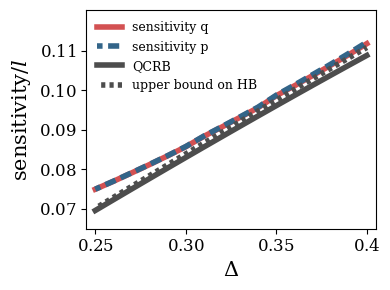

In [30]:
name = 'data-sensitivity-delta-bounds'
with open(path_QS_figures_data+name+'.pkl', 'rb') as f:
    data = pickle.load(f)

sensitivity_q_delta = data['sensitivity_q_delta']
sensitivity_p_delta = data['sensitivity_p_delta']
CR_delta = data['CR_delta']
HB_delta = data['HB_delta']
Delta_range = data['Delta_range']

fig, ax = plt.subplots(1,1,figsize=(4,3),sharex=True)
ax.plot(Delta_range, sensitivity_q_delta/l, color=lighten_color(red,.7), lw=4, label='sensitivity q')
ax.plot(Delta_range, sensitivity_p_delta/l, color=blue, lw=4, label='sensitivity p',ls=(1,(2,1)))
ax.plot(Delta_range, CR_delta/l, color=lighten_color('black',.7), lw=4, label='QCRB')
ax.plot(Delta_range, HB_delta/l, color=lighten_color('black',.7), lw=4, label='upper bound on HB',ls=(.75,(.75,.75)))
ax.set_xlabel(r'$\Delta$',fontsize=15)
ax.set_ylabel(r'$\text{sensitivity}/l$',fontsize=15)
ax.set_ylim(0.065,.1203)
ax.set_xlim(0.245,0.405)
y1labels = [r'$0.07$',r'$0.08$',r'$0.09$',r'$0.10$',r'$0.11$']
y1ticks = [.07,.08,.09,.1,.11]
xticks = [.25,.3,.35, .4]
xlabels = [r'$0.25$',r'$0.30$',r'$0.35$',r'$0.4$']
ax.set_yticks(y1ticks)
ax.set_yticklabels(y1labels,fontsize=12)
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels,fontsize=12)
ax.legend(fontsize=9,loc='upper left',framealpha=0)

name =  'appendix-Fig8-sensitivity-delta-bounds'
plt.tight_layout()
plt.savefig(path_QS_figures+name+'.pdf',bbox_inches='tight',dpi=1000)
plt.show()

0.17581424743261687
0.2103371737576449
0.24439053822967885
0.27779663909930613


/var/folders/vk/yq14ng8x7rd4q_4cz8t84tj80000gq/T/ipykernel_87510/3506830052.py:38: UserWarning: Legend does not support handles for NoneType instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  ax1.legend(handles, labels, fontsize=6,loc='upper right',framealpha=0,ncol=2)


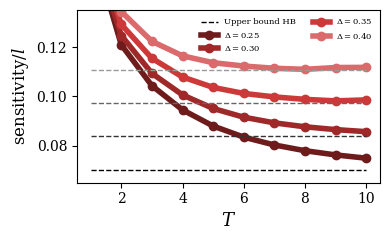

In [31]:
fig, ax1 = plt.subplots(1,1,figsize=(4,2.5))
# ax1, ax2 = ax

name = 'data-noiseless-sensitivity-convergence'
dict_sensitivities = np.load(path_QS_figures_data+name+'.npz',allow_pickle=True)
sensitivities = dict_sensitivities['min_sensitivities']
delta_range = dict_sensitivities['Delta_range']
Holevo_bounds = dict_sensitivities['Holevo_bounds']
T_range = dict_sensitivities['T_range']

lines = []
labels = []
for i in range(len(sensitivities)):
    sensitivity = sensitivities[i]
    Delta = delta_range[i]
    T = T_range[i]
    Holevo_bound = np.real(Holevo_bounds[i])
    shine = 1.1 - 0.2*i
    print(Holevo_bound)
    if i==0:
        line2, = ax1.plot(T_range, sensitivity/l, color=lighten_color(red,1.2-.2*i),lw=4,label=r'$\Delta={0:.2f}$'.format(Delta),marker='o')
        line1, = ax1.plot(T_range, Holevo_bound*np.ones(len(T_range))/l, color=lighten_color('black',1),lw=1,ls='--',label=r'Upper bound HB')
        lines.append(line1)
        labels.append(line1.get_label())
        lines.append(None)
        labels.append('')
    else:
        line2, = ax1.plot(T_range, sensitivity/l, color=lighten_color(red,1.2-.2*i),lw=4,label=r'$\Delta={0:.2f}$'.format(Delta),marker='o')
        ax1.plot(T_range, Holevo_bound*np.ones(len(T_range))/l, color=lighten_color('black',1-.2*i),lw=1,ls='--')
    lines.append(line2)
    labels.append(line2.get_label())

handles = lines
# labels = [h.get_label() for h in handles]
ax1.set_xlabel(r'$T$',fontsize=13)
ax1.set_ylabel(r'$\text{sensitivity}/l$',fontsize=12)
ax1.set_ylim(.065,.135)
ax1.legend(handles, labels, fontsize=6,loc='upper right',framealpha=0,ncol=2)

name = 'appendix-fig9-sensitivity-convergence'
plt.tight_layout()
fig.savefig(path_QS_figures+name+'.pdf',format='pdf',dpi=1000,bbox_inches='tight')
plt.show()


### Gaussian variance

/var/folders/vk/yq14ng8x7rd4q_4cz8t84tj80000gq/T/ipykernel_91797/2505653421.py:57: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  ax.legend(handles, labels,loc='upper right',fontsize=9,frameon=True,ncol=2)


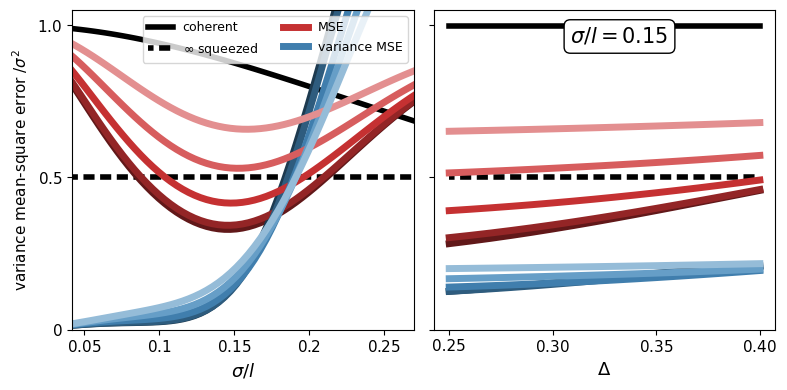

In [9]:
name = 'data-noiseless-gaussian-mse-variance'
dict_figure = np.load(path_QS_figures_data+name+'.npz',allow_pickle=True)
T_range = dict_figure['T_range']
Delta_range = dict_figure['Delta_range']
MSE_all = dict_figure['MSE_all']
MSE2_all = dict_figure['MSE2_all']
mse_delta_all = dict_figure['mse_delta_all']
variance_delta_all = dict_figure['variance_delta_all']
stddev_range = dict_figure['stddev_range']
coherent_limit = dict_figure['coherent_limit']
gaussian_limit = dict_figure['gaussian_limit']
variance_list = stddev_range**2

fig, axs = plt.subplots(1,2,figsize=(8,4), sharey=True)
ax, ax2 = axs

line1, = ax.plot(stddev_range, coherent_limit,color='black',ls='-',lw=4,label='coherent')
line2, = ax.plot(stddev_range, gaussian_limit,color='black',ls=(1,(2,1)),lw=4,label=r'$\infty$ squeezed')
lines = [line1,line2]
for i in range(5):
    MSE = MSE_all[i]
    MSE2 = MSE2_all[i]
    shine = 1.25-.2*i
    if i==2:
        line3, = ax.plot(stddev_range,MSE/stddev_range**2,color=lighten_color(red,shine),lw=5,label='MSE')
        line4, = ax.plot(stddev_range,(MSE2-MSE**2)/stddev_range**2,color=lighten_color(blue,shine),lw=5,ls='-', label='variance MSE')
    else:
        line3, = ax.plot(stddev_range,MSE/stddev_range**2,color=lighten_color(red,shine),lw=5)
        line4, = ax.plot(stddev_range,(MSE2-MSE**2)/stddev_range**2,color=lighten_color(blue,shine),lw=5,ls='-')
    lines.append(line3)
    lines.append(line4)

index = np.argmin(stddev_range - 0.15*l)
ax2.plot(Delta_range, coherent_limit[index]*np.ones(len(Delta_range)),color='black',ls='-',lw=4,label='coherent')
ax2.plot(Delta_range, gaussian_limit[index]*np.ones(len(Delta_range)),color='black',ls=(1,(2,1)),lw=4,label=r'$\infty$ squeezed')
for i in range(5):
    shine = 1.25-.2*i
    variance_delta = variance_delta_all[i]
    mse_delta = mse_delta_all[i]
    ax2.plot(Delta_range,mse_delta,color=lighten_color(red,shine),lw=5,ls='-', label='variance MSE')
    ax2.plot(Delta_range,variance_delta,color=lighten_color(blue,shine),lw=5,ls='-', label='variance MSE')

handles = lines
labels = [h.get_label() for h in handles]

l = np.sqrt(2*np.pi)
ax.set_xlim(0.042*l,0.27*l)
ax.set_ylim(.0,1.05)
ax.set_xlabel(r'$\sigma/l$',fontsize=13)
ax.set_xticks([0.05*l,0.1*l,0.15*l,0.2*l,0.25*l])
ax.set_yticks([0,0.5,1])
xlabels = [r'$0.05$',r'$0.1$',r'$0.15$',r'$0.2$',r'$0.25$']
ylabels = [r'0',r'$0.5$',r'$1.0$']
ax.set_xticklabels(xlabels,fontsize=11)
ax.set_yticklabels(ylabels,fontsize=11)
ax.set_ylabel(r'$\text{variance mean-square error }/\sigma^2$',fontsize=11)
ax.legend(handles, labels,loc='upper right',fontsize=9,frameon=True,ncol=2)

ax2.set_xticks([0.25,0.3,0.35,0.4])
xlabels = [r'0.25',r'$0.30$',r'$0.35$',r'$0.40$']
ax2.set_xticklabels(xlabels,fontsize=11)

ax2.set_xlabel(r'$\Delta$',fontsize=13)

# Add textbox with sigma value
ax2.text(0.4, 0.95, r'$\sigma/l = 0.15$', transform=ax2.transAxes, fontsize=15,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', edgecolor='black'))
ax2.set_ylim(0,1.05)

name = 'appendix-fig10-gaussian-mse-variance'
plt.tight_layout()
fig.savefig(path_QS_figures+name+'.pdf',format='pdf',dpi=1000,bbox_inches='tight')
plt.show()

### Backaction

9
j 2
(20,) (20,)
fidelity_95: 0.27
j 4
(20,) (20,)
fidelity_95: 0.29
j 6
(20,) (20,)
fidelity_95: 0.3
j 8
(20,) (20,)
fidelity_95: 0.31


/var/folders/vk/yq14ng8x7rd4q_4cz8t84tj80000gq/T/ipykernel_99259/120906065.py:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


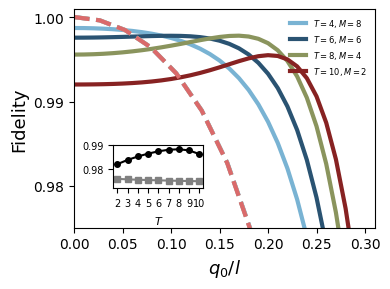

In [4]:
Delta, k, steps3 = 0.3, 0, 20

name = 'data-figure-fidelities-BA.pkl'
with open(path_QS_figures_data+name, 'rb') as f:
    dict_fidelities = pickle.load(f)
fidelities_yes_all = dict_fidelities['fidelities_yes_simple_all']
fidelities_no_all = dict_fidelities['fidelities_no_all']
q_test = dict_fidelities['q_test']
print(len(fidelities_yes_all))
q_test2 = (l/2)*np.linspace(0,1.0,20)

# name = 'data-figure-fidelities-BA.pkl'
# with open(path_QS_figures_data+name, 'rb') as f:
#     dict_fidelities = pickle.load(f)
# fidelities_no_all = dict_fidelities['fidelities_no_all']
# q_test2 = dict_fidelities['q_test']

fig, ax = plt.subplots(1,1,figsize=(4,3))

T_range = np.arange(2,11)
# T_range = np.arange(2,11)  # Range of T values
# M_range = np.arange(10,13,2)
M_range = [10]
T_dict = {4:8,6:6,8:4,10:2}  # Mapping T to the corresponding M value
styles = ['-',(2,(2,1)),(1,(1,1)),(1,(1,2))]
colors_dict = {4:light_blue,6:blue,8:green,10:red}
for j in range(len(T_range)):
    if T_range[j] not in [4,6,8,10]:
        continue
    print('j',j)

    # style = styles[j]
    # for i in range(len(M_range)):
        # M = M_range[i]
    shine = .5 + .25*j
    T = T_range[j]
    M = T_dict[T_range[j]]

    avg_fidelities_yes = fidelities_yes_all[j]
    avg_fidelities_no = fidelities_no_all[j]
    
    ax.plot(q_test/l,avg_fidelities_yes,color=lighten_color(colors_dict[T],1.1),lw=3, ls='-',label='$T={0:.0f}, M={1}$'.format(T_range[j],M))
    print(avg_fidelities_no.shape, q_test2.shape)
    ax.plot(q_test2/l,avg_fidelities_no,color=lighten_color(colors_dict[T],.6),lw=3,ls='--')

    fidelity_95 = q_test[np.argmin(np.abs(avg_fidelities_yes-.95))]
    print('fidelity_95:',fidelity_95/l)

T_range = np.arange(2,11)
sigma = 0.15 * l
weighted_fidelities_yes = np.zeros(len(T_range))
weighted_fidelities_no = np.zeros(len(T_range))
for i in range(len(T_range)):
    prior = np.exp(-q_test**2/(2*sigma**2))
    prior /= np.sum(prior)
    prior2 = np.exp(-q_test2**2/(2*sigma**2))
    prior2 /= np.sum(prior2)
    avg_fidelities_yes = fidelities_yes_all[i]
    avg_fidelities_no = fidelities_no_all[i]
    weighted_fidelities_yes[i] = np.sum(avg_fidelities_yes * prior)
    weighted_fidelities_no[i] = np.sum(avg_fidelities_no * prior2)

# Add an inset axis for weighted fidelities
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
ax_inset = inset_axes(
    ax,
    width="100%", height="100%",
    loc='upper left',
    bbox_to_anchor=(0.13, 0.18, 0.3, 0.2),  # (x0, y0, width, height) in axes fraction
    bbox_transform=ax.transAxes,
    borderpad=0
)# Plot weighted fidelities in the inset
ax_inset.plot(T_range, weighted_fidelities_yes, marker='o', color='black', markersize=4, linestyle='-', lw=1.5)
ax_inset.plot(T_range, weighted_fidelities_no, marker='s', color='gray', markersize=4, linestyle='-', lw=1.5)
ax_inset.set_xlabel(r'$T$', fontsize=8)
# ax_inset.set_ylabel(r'$\bar F$', fontsize=8)
ax_inset.tick_params(axis='both', labelsize=7)
ax_inset.set_xticks(T_range)
ax_inset.set_ylim(min(weighted_fidelities_yes)*0.99, .99)

    

dict_figure = {}
dict_figure['fidelities_yes_all'] = fidelities_yes_all
dict_figure['fidelities_no_all'] = fidelities_no_all
dict_figure['q_test'] = q_test
dict_figure['q_test2'] = q_test2
dict_figure['weighted_fidelities_yes'] = weighted_fidelities_yes
dict_figure['weighted_fidelities_no'] = weighted_fidelities_no
name = 'data-figure-backaction-fidelities'
np.savez(path_QS_figures_data+name+'.npz', **dict_figure)

ax.set_ylim(.975,1.001)
ax.set_xlim(0,.31)
ax.legend(fontsize=6,loc='upper right',framealpha=0,ncol=1)
ax.set_xlabel(r'$q_0/l$',fontsize=13)
ax.set_ylabel(r'Fidelity',fontsize=13)
ax.set_yticks([.98,.99,1.0])
plt.tight_layout()
name = 'appendix-fig11-BA-fidelities'
fig.savefig(path_QS_figures+name+'.pdf',format='pdf',dpi=1000,bbox_inches='tight')
plt.show()

## Noise

### fidelity and contrast Yale noise

fidelity 0 2.0 0.9721637328036722
fidelity 1 1.0 0.9450783241399425
fidelity 2 0.75 0.9275796326684361
fidelity 3 0.5 0.8939272443440114
fidelity 4 0.25 0.7947192120747582


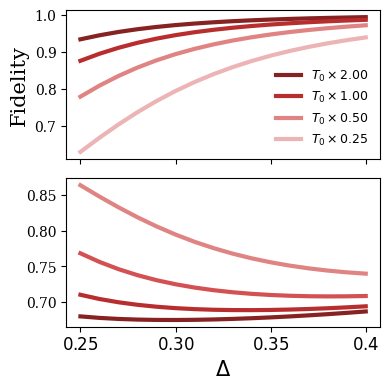

In [ ]:
fig, axs = plt.subplots(2,1, figsize=(4,4),sharex=True,gridspec_kw={'height_ratios': [1, 1]})
ax, ax2 = axs

name = 'appendix-fidelities-delta.npz'
dict_fidelity = np.load(path_QS_figures_data+name,allow_pickle=True)
fidelities = dict_fidelity['fidelity']
ratios = dict_fidelity['ratios']

name = 'data-figure-min-MSE-noise-1-round'
dict_min_MSE = np.load(path_QS_figures_data+name+'.npz',allow_pickle=True)
delta_range = dict_min_MSE['delta_range']
MSE_mins_025 = dict_min_MSE['MSE_mins_025']
MSE_mins_05 = dict_min_MSE['MSE_mins_05']
MSE_mins_1 = dict_min_MSE['MSE_mins_1']
MSE_mins_2 = dict_min_MSE['MSE_mins_2']
MSE_all = [MSE_mins_2, MSE_mins_1, MSE_mins_05, MSE_mins_025]

delta_range = np.arange(.25,.41,.01)
index_30 = np.argmin(np.abs(delta_range-.3))
# ratios = [.25,.5,.75,1.0]
for i in range(5):
    print('fidelity',i,ratios[4-i],fidelities[4-i][index_30])
    if i==2:
        pass
    else:
        shine = 1.1 -.2*i
        ax.plot(delta_range,fidelities[4-i], lw=3, color=lighten_color(red,shine),ls='-',label=r'$T_0\times {0:.2f}$'.format(ratios[4-i]))

for i in range(4):
    shine = 1.1 -.2*i
    ax2.plot(delta_range, MSE_all[i], lw=3, color=lighten_color(red,shine),ls='-',label=r'$T_0\times {0:.2f}$'.format(ratios[i]))

ax2.set_xlabel(r'$\Delta$',fontsize=15)
ax.set_ylabel(r'Fidelity',fontsize=15)


xticks = [.25,.3,.35, .4]
xlabels = [r'$0.25$',r'$0.30$',r'$0.35$',r'$0.4$']
ax2.set_xticks(xticks)
ax2.set_xticklabels(xlabels,fontsize=12)
ax.legend(fontsize=9,loc='lower right',framealpha=0)
name = 'appendix-fidelities-delta'
plt.tight_layout()
plt.savefig(path_figures+name+'.pdf',bbox_inches='tight',dpi=1000)
plt.show()

### fidelity sBs steady state

4 4
sensitivities_noiseless [0.09453187 0.10053561 0.10783426 0.11637886]
fidelity 0 2.0 0.9721637328036722
fidelity 1 1.0 0.9450783241399425
fidelity 2 0.5 0.8939272443440114
fidelity 3 0.25 0.7947192120747582


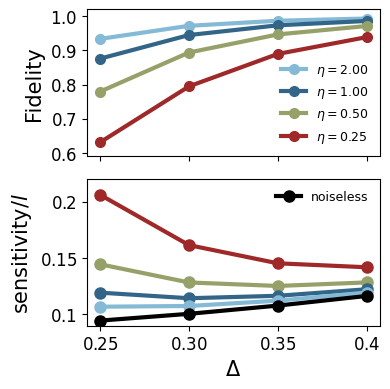

In [15]:
fig, axs = plt.subplots(2,1, figsize=(4,4),sharex=True,gridspec_kw={'height_ratios': [1, 1]})
ax, ax2 = axs

name = 'appendix-fidelities-delta.npz'
dict_fidelity = np.load(path_QS_figures_data+name,allow_pickle=True)
fidelities = dict_fidelity['fidelity']
ratios = dict_fidelity['ratios']
print(len(fidelities), len(ratios))

name = 'data-figure-min-sensitivities-noise-deltas'
dict_min_sensitivities = np.load(path_QS_figures_data+name+'.npz',allow_pickle=True)
min_sens_025 = dict_min_sensitivities['min_sens_025']
min_sens_050 = dict_min_sensitivities['min_sens_050']
min_sens_1 = dict_min_sensitivities['min_sens_1']
min_sens_2 = dict_min_sensitivities['min_sens_2']
Delta_range = [.25,.3,.35,.4]

sensitivities_noiseless = []
for Delta in Delta_range:
    name = 'data-noiseless-sensitivity-fullqmap-delta={0:.2f}-T={1:.0f}'.format(Delta,4)
    with open(path_QS_noiseless_results+name+'.pkl', 'rb') as file:
        dictionary = pickle.load(file)
    MSE = dictionary['MSE']
    biases = dictionary['biases']
    partial_means = dictionary['partial_means']
    FIqT = dictionary['FIqT']
    sensitivity = np.sqrt(MSE/partial_means**2)
    sensitivities_noiseless.append(np.min(sensitivity))
    
print('sensitivities_noiseless',sensitivities_noiseless/l)
# name = 'data-figure-sensitivities-state-vs-metrology.npz'
# dict_figure = np.load(path_QS_figures_data+name,allow_pickle=True)
# sensitivities_noiseless = dict_figure['sensitivities_noiseless']

delta_range = np.arange(.25,.41,.01)
index_25 = np.argmin(np.abs(delta_range-.25))
index_30 = np.argmin(np.abs(delta_range-.3))
index_35 = np.argmin(np.abs(delta_range-.35))
index_40 = np.argmin(np.abs(delta_range-.4))
index_list = [index_25, index_30, index_35, index_40]
colors = [light_blue, blue, green, red]
for i in range(4):
    print('fidelity',i,ratios[3-i],fidelities[3-i][index_30])
    shine = 1.1 -.2*i
    ax.plot([delta_range[j] for j in index_list],[fidelities[3-i][j] for j in index_list], lw=3, color=colors[i],ls='-',label=r'$\eta =  {0:.2f}$'.format(ratios[3-i]),marker='o',markersize=7)

ax2.plot(Delta_range, min_sens_025/l, lw=3, color=lighten_color(red,1),ls='-',marker='o', markersize=8)
ax2.plot(Delta_range, min_sens_050/l, lw=3, color=lighten_color(green,1),ls='-',marker='o', markersize=8)
ax2.plot(Delta_range, min_sens_1/l, lw=3, color=lighten_color(blue,1),ls='-',marker='o', markersize=8)
ax2.plot(Delta_range, min_sens_2/l, lw=3, color=lighten_color(light_blue,1),ls='-',marker='o', markersize=8)
ax2.plot(Delta_range, sensitivities_noiseless/l, lw=3, color=lighten_color('black',1),ls='-',marker='o', markersize=8,label='noiseless')

xticks = [.25,.3,.35, .4]
xlabels = [r'$0.25$',r'$0.30$',r'$0.35$',r'$0.4$']
ax2.set_xticks(xticks)
ax2.set_xticklabels(xlabels,fontsize=12)
yticks = [.6,.7,.8,.9,1.0]
ylabels = [r'$0.6$',r'$0.7$',r'$0.8$',r'$0.9$',r'$1.0$']
ax.set_ylim(.59,1.02)
ax.set_yticks(yticks)
ax.set_yticklabels(ylabels,fontsize=12)
yticks = [.1,.15,.2]
ylabels = [r'$0.1$',r'$0.15$',r'$0.2$']
ax2.set_yticks(yticks)
ax2.set_yticklabels(ylabels,fontsize=12)
ax2.set_ylim(0.09,.22)
ax.legend(fontsize=9,loc='lower right',framealpha=0)
ax2.set_xlabel(r'$\Delta$',fontsize=15)
ax.set_ylabel(r'Fidelity',fontsize=15)
ax2.set_ylabel(r'$\text{sensitivity}/l$',fontsize=15)
ax2.legend(fontsize=9,loc='upper right',framealpha=0)
name = 'appendix-fig12-noise-fidelities-sensitivites-delta'
plt.tight_layout()
plt.savefig(path_QS_figures+name+'.pdf',bbox_inches='tight',dpi=1000)
plt.show()

### fidelity each noise

/var/folders/vk/yq14ng8x7rd4q_4cz8t84tj80000gq/T/ipykernel_1175/2351202307.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(xlabels,fontsize=12)


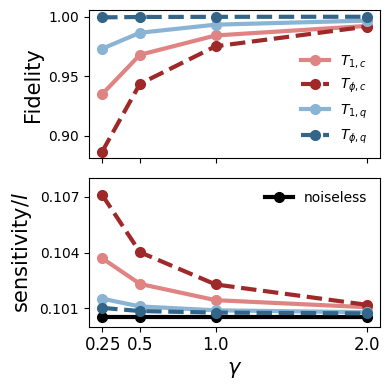

In [28]:
fig, axs = plt.subplots(2,1, figsize=(4,4),sharex=True,gridspec_kw={'height_ratios': [1, 1]})
ax, ax2 = axs

name = 'data-figure-fidelities-eachnoise.npz'
dict_fidelity = np.load(path_QS_figures_data+name,allow_pickle=True)
ratios = dict_fidelity['ratios']
fidelities_T1c = dict_fidelity['fidelities_T1c']
fidelities_T2c = dict_fidelity['fidelities_T2c']
fidelities_T1q = dict_fidelity['fidelities_T1q']
fidelities_T2q = dict_fidelity['fidelities_T2q']

name = 'data-figure-sensitivities-eachnoise.npz'
dict_sensitivities = np.load(path_QS_figures_data+name,allow_pickle=True)
sensitivities_T1c = dict_sensitivities['sensitivities_T1c']
sensitivities_T2c = dict_sensitivities['sensitivities_T2c']
sensitivities_T1q = dict_sensitivities['sensitivities_T1q']
sensitivities_T2q = dict_sensitivities['sensitivities_T2q']
min_s_T1c = dict_sensitivities['min_s_T1c']
min_s_T2c = dict_sensitivities['min_s_T2c']
min_s_T1q = dict_sensitivities['min_s_T1q']
min_s_T2q = dict_sensitivities['min_s_T2q']

Delta = 0.3
sensitivities_noiseless = []
name = 'data-noiseless-sensitivity-fullqmap-delta={0:.2f}-T={1:.0f}'.format(Delta,4)
with open(path_QS_noiseless_results+name+'.pkl', 'rb') as file:
    dictionary = pickle.load(file)
MSE = dictionary['MSE']
biases = dictionary['biases']
partial_means = dictionary['partial_means']
FIqT = dictionary['FIqT']
sensitivity_noiseless = np.min(np.sqrt(MSE/partial_means**2))

ax.plot(ratios, [fidelities_T1c[i] for i in [0,1,3,-1]], lw=3, color=lighten_color(red,.5), ls='-', label=r'$T_{1,c}$',marker='o',markersize=7)
ax.plot(ratios, [fidelities_T2c[i] for i in [0,1,3,-1]], lw=3, color=lighten_color(red,1), ls='--', label=r'$T_{\phi,c}$',marker='o',markersize=7)
ax.plot(ratios, [fidelities_T1q[i] for i in [0,1,3,-1]], lw=3, color=lighten_color(blue,.5),  ls='-', label=r'$T_{1,q}$',marker='o',markersize=7)
ax.plot(ratios, [fidelities_T2q[i] for i in [0,1,3,-1]], lw=3, color=lighten_color(blue,1),  ls='--', label=r'$T_{\phi,q}$',marker='o',markersize=7)

ax2.plot(ratios, sensitivity_noiseless/l*np.ones(4), lw=3, color=lighten_color('black',1), ls='-', label='noiseless',marker='o',markersize=7)

ax2.plot(ratios, min_s_T1c/l, lw=3, color=lighten_color(red,.5), ls='-', label=None,marker='o',markersize=7)
ax2.plot(ratios, min_s_T2c/l, lw=3, color=lighten_color(red,1), ls='--', label=None,marker='o',markersize=7)
ax2.plot(ratios, min_s_T1q/l, lw=3, color=lighten_color(blue,.5),  ls='-', label=None,marker='o',markersize=7)
ax2.plot(ratios, min_s_T2q/l, lw=3, color=lighten_color(blue,1),  ls='--', label=None,marker='o',markersize=7)


xlabels = [r'$0.25$',r'$0.5$',r'$1.0$',r'$2.0$']
ax2.set_xticklabels(xlabels,fontsize=12) 
ax2.set_xlabel(r'$\gamma$',fontsize=15)
ax.set_ylabel(r'Fidelity',fontsize=15)
ax2.set_ylabel(r'sensitivity$/l$',fontsize=15)
ax.set_yticks([.9,.95,1.0])
ax2.set_xticks([.25,.5,1,2])
ax2.set_yticks([.101,.104,.107])
ax2.set_ylim(.1,.108)
ax.legend(fontsize=10,loc='lower right',framealpha=0)
ax2.legend(fontsize=10,loc='upper right',framealpha=0)
name = 'appendix-fig15-fidelities-sensitivities-eachnoise'
plt.tight_layout()
plt.savefig(path_QS_figures+name+'.pdf',bbox_inches='tight',dpi=1000)
plt.show()

### Preparation vs during metrology noise

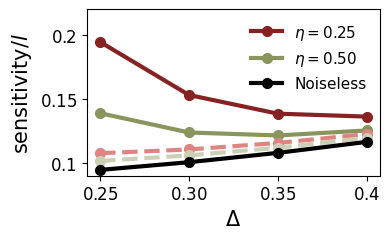

In [27]:

name = 'data-figure-sensitivities-state-vs-metrology.npz'
dict_figure = np.load(path_QS_figures_data+name,allow_pickle=True)
Delta_range = dict_figure['Delta_range']
sensitivities_025_noisystate = dict_figure['sensitivities_025_noisystate']
sensitivities_050_noisystate = dict_figure['sensitivities_050_noisystate']
sentivities_1_noisystate = dict_figure['sensitivities_1_noisystate']
sensitivities_2_noisystate = dict_figure['sensitivities_2_noisystate']
sensitivities_025_idealstate = dict_figure['sensitivities_025_idealstate']
sensitivities_050_idealstate = dict_figure['sensitivities_050_idealstate']
sensitivities_1_idealstate = dict_figure['sensitivities_1_idealstate']
sensitivities_2_idealstate = dict_figure['sensitivities_2_idealstate']
# sensitivities_noiseless = dict_figure['sensitivities_noiseless']

sensitivities_noiseless = []
for Delta in Delta_range:
    name = 'data-noiseless-sensitivity-fullqmap-delta={0:.2f}-T={1:.0f}'.format(Delta,4)
    with open(path_QS_noiseless_results+name+'.pkl', 'rb') as file:
        dictionary = pickle.load(file)
    MSE = dictionary['MSE']
    biases = dictionary['biases']
    partial_means = dictionary['partial_means']
    FIqT = dictionary['FIqT']
    sensitivity = np.sqrt(MSE/partial_means**2)
    sensitivities_noiseless.append(np.min(sensitivity))

fig, ax = plt.subplots(1,1, figsize=(4,2.5))

ax.plot(Delta_range, sensitivities_025_noisystate/l, lw=3, color=lighten_color(red,1.1), ls='-', label=r'$\eta = 0.25$',marker='o',markersize=7)
ax.plot(Delta_range, sensitivities_050_noisystate/l, lw=3, color=lighten_color(green,1.1), ls='-', label=r'$\eta = 0.50$',marker='o',markersize=7)
# ax.plot(Delta_range, sentivities_1_noisystate/l, lw=3, color=lighten_color(blue,1.1), ls='-', label=r'$\gamma = 1.00$',marker='o',markersize=7)

ax.plot(Delta_range, sensitivities_025_idealstate/l, lw=3, color=lighten_color(red,.5), ls='--', label=None,marker='o',markersize=7)
ax.plot(Delta_range, sensitivities_050_idealstate/l, lw=3, color=lighten_color(green,.5), ls='--', label=None,marker='o',markersize=7)
# ax.plot(Delta_range, sensitivities_1_idealstate/l, lw=3, color=lighten_color(blue,.5), ls='--', label=None,marker='o',markersize=7)

ax.plot(Delta_range, sensitivities_noiseless/l, lw=3, color=lighten_color('black',1), ls='-', label='Noiseless',marker='o',markersize=7)

xticks = [.25,.3,.35, .4]
xlabels = [r'$0.25$',r'$0.30$',r'$0.35$',r'$0.4$']
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels,fontsize=12)
yticks = [.1,.15,.2]
ylabels = [r'$0.1$',r'$0.15$',r'$0.2$']
ax.set_yticks(yticks)
ax.set_yticklabels(ylabels,fontsize=12)
ax.set_ylim(0.09,.22)
ax.legend(fontsize=11,loc='upper right',framealpha=0)
ax.set_xlabel(r'$\Delta$',fontsize=15)
ax.set_ylabel(r'Fidelity',fontsize=15)
ax.set_ylabel(r'$\text{sensitivity}/l$',fontsize=15)
name = 'appendix-fig13-idealstate-vs-noisystate-sensitivities'
plt.tight_layout()

plt.savefig(path_QS_figures+name+'.pdf',bbox_inches='tight',dpi=1000)
plt.show()


### q vs p

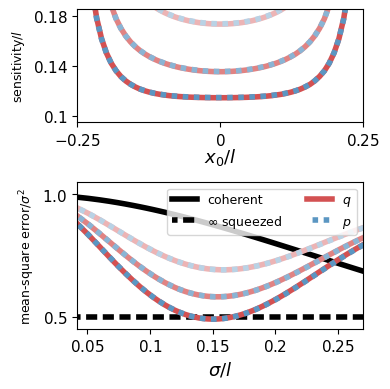

In [26]:
name = 'data-sensitivities-MSE-q-p'
dict_figure = np.load(path_QS_figures_data+name+'.npz',allow_pickle=True)
sensitivities_p = dict_figure['sensitivities_p']
sensitivities_q = dict_figure['sensitivities_q']
MSE_q = dict_figure['MSE_q']
MSE_p = dict_figure['MSE_p']
stddev_range = dict_figure['stddev_range']
vlist = dict_figure['vlist']

fig, axs = plt.subplots(2,1, figsize=(4,4), gridspec_kw={'height_ratios': [1, 1.3]})
ax, ax2 = axs
plt.subplots_adjust(hspace=0.4)  # Increase vertical space (try values like 0.3, 0.4, 0.5)


def coherent_limit(v):
    return 1/(v+1)
def gaussian_limit(v):
    return v/2/v

line1, = ax2.plot(stddev_range/l, coherent_limit(stddev_range**2),color='black',ls='-',lw=4,label='coherent')
line2, = ax2.plot(stddev_range/l, gaussian_limit(stddev_range**2),color='black',ls=(1,(2,1)),lw=4,label=r'$\infty$ squeezed')
lines = [line1,line2]


T_range = [1,2,4]
for i in range(3):
    T = T_range[i]
    shine = .3+.2*i
    if i==2:
        line3, = ax.plot(vlist/l, sensitivities_q[i]/l, color=lighten_color(red,shine), lw=4, label=r'$q$')
        line4, = ax.plot(vlist/l, sensitivities_p[i]/l, color=lighten_color(blue,shine), lw=4, label=r'$p$',ls=(1, (1, 1)))
    else:
        ax.plot(vlist/l, sensitivities_q[i]/l, color=lighten_color(red,shine), lw=4)
        ax.plot(vlist/l, sensitivities_p[i]/l, color=lighten_color(blue,shine), lw=4, ls=(1, (1, 1)))
lines.append(line3)
lines.append(line4)

for i in range(3):
    T = T_range[i]
    shine = .3+.2*i
    if i==0:
        line3, = ax2.plot(stddev_range/l, MSE_q[i]/stddev_range**2, color=lighten_color(red,shine), lw=4, label=r'$q$')
        line4, = ax2.plot(stddev_range/l, MSE_p[i]/stddev_range**2, color=lighten_color(blue,shine), lw=4, label=r'$p$',ls=(1, (1, 1)))
    else:
        ax2.plot(stddev_range/l, MSE_q[i]/stddev_range**2, color=lighten_color(red,shine), lw=4)
        ax2.plot(stddev_range/l, MSE_p[i]/stddev_range**2, color=lighten_color(blue,shine), lw=4, ls=(1, (1, 1)))

handles = lines
labels = [h.get_label() for h in handles]
ax2.legend(handles, labels,loc='upper right',fontsize=9,frameon=True,ncol=2)

ax.set_ylim(0.095,.185)
ax.set_xlim(-.25,.25)
xticks = [-1/4,0,1/4]
xlabels = [r'$-0.25$',r'$0$',r'$0.25$']
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels,fontsize=11)
ax.set_xlabel(r'$x_0/l$',fontsize=13,labelpad=-1)
y1ticks = [.1,.14, .18]
y1labels = [r'$0.1$',r'$0.14$',r'$0.18$']
ax.set_yticks(y1ticks)
ax.set_yticklabels(y1labels,fontsize=11)
ax.set_ylabel(r'$\text{sensitivity}/l$',fontsize=9)

l = np.sqrt(2*np.pi)
ax2.set_xlim(0.042,0.27)
ax2.set_ylim(.45,1.05)
ax2.set_xlabel(r'$\sigma/l$',fontsize=13)
ax2.set_xticks([0.05,0.1,0.15,0.2,0.25])
ax2.set_yticks([0.5,1])
xlabels = [r'$0.05$',r'$0.1$',r'$0.15$',r'$0.2$',r'$0.25$']
ylabels = [r'$0.5$',r'$1.0$']
ax2.set_xticklabels(xlabels,fontsize=11)
ax2.set_yticklabels(ylabels,fontsize=11)
ax2.set_ylabel(r'$\text{mean-square error}/\sigma^2$',fontsize=9)

name = 'appendix-fig14-q-vs-p-sensitivities-MSE'
plt.tight_layout()
plt.savefig(path_QS_figures+name+'.pdf',format='pdf',dpi=1000,bbox_inches='tight')
plt.show()

### qubit relaxation

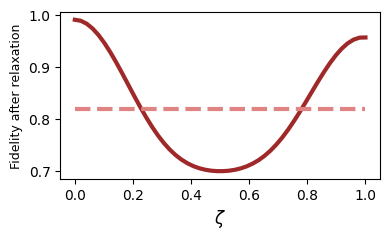

In [33]:
name = 'data-relaxation-qubit'
dict_figure  = np.load(path_QS_figures_data+name+'.npz',allow_pickle=True)
fidelities = dict_figure['fidelities']
beta_range = dict_figure['beta_range']
F_gg = fidelities[:, 0]
F_ee = fidelities[:, 1]

fig, ax = plt.subplots(1,1, figsize=(4,2.5))
ax.plot(beta_range, F_gg, lw=3, color=lighten_color(red,1), ls='-', label=r'$F_{gg}$')
ax.plot(beta_range, np.average(F_gg)*np.ones(len(beta_range)), lw=3, color=lighten_color(red,.5), ls='--', label=r'average $F_{gg}$')

ax.set_xlabel(r'$\zeta $',fontsize=12)
ax.set_ylabel(r'Fidelity after relaxation',fontsize=9)
plt.tight_layout()

name = 'appendix-fig16-qubit-relaxation-fidelities'
plt.savefig(path_QS_figures+name+'.pdf',format='pdf',dpi=1000,bbox_inches='tight')
plt.show()


### Fidelity backaction

j 0
j 2
j 4
j 6
weighted_fidelities_yes: [0.9915773  0.99194042 0.99162128 0.99045596 0.98811734 0.98412044
 0.97776296]
weigthed_fidelities_noiseless_yes: [0.9820499  0.98377426 0.98516935 0.98633052 0.98726666 0.98790777
 0.98811256 0.98764756 0.98616488]


/var/folders/vk/yq14ng8x7rd4q_4cz8t84tj80000gq/T/ipykernel_1175/794366966.py:105: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


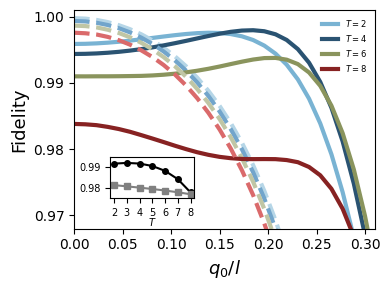

In [35]:
Delta, k, steps3 = 0.3, 0, 20


# dict_figure = {}
# dict_figure['fidelities_yes_all'] = fidelities_yes_all
# dict_figure['fidelities_no_all'] = fidelities_no_all
# dict_figure['q_test'] = q_test
# dict_figure['q_test2'] = q_test2
# dict_figure['weighted_fidelities_yes'] = weighted_fidelities_yes
# dict_figure['weighted_fidelities_no'] = weighted_fidelities_no
name = 'data-figure-backaction-fidelities'
dict_figure = np.load(path_QS_figures_data+name+'.npz',allow_pickle=True)
weigthed_fidelities_noiseless_yes = dict_figure['weighted_fidelities_yes']
weigthed_fidelities_noiseless_no = dict_figure['weighted_fidelities_no']

name = 'data-figure-noisy-backaction-fidelities'
dict_figure = np.load(path_QS_figures_data+name+'.npz',allow_pickle=True)
no_recovery_fidelities = dict_figure['no_recovery_fidelities']
prior_avg_no_recovery_fidelities = dict_figure['prior_avg_no_recovery_fidelities']
recovery_fidelities = dict_figure['recovery_fidelities']
prior_avg_recovery_fidelities = dict_figure['prior_avg_recovery_fidelities']
q_test = dict_figure['qrange']
q_test2 = dict_figure['qrange2']
T_range = dict_figure['T_range']
sigma = dict_figure['sigma']

# name = 'data-figure-fidelities-BA.pkl'
# with open(path_QS_figures_data+name, 'rb') as f:
#     dict_fidelities = pickle.load(f)
# fidelities_yes_all = dict_fidelities['fidelities_yes_simple_all']
# fidelities_no_all = dict_fidelities['fidelities_no_all']
# q_test = dict_fidelities['q_test']
# print(len(fidelities_yes_all))
# q_test2 = (l/2)*np.linspace(0,1.0,20)


fig, ax = plt.subplots(1,1,figsize=(4,3))

T_range = np.arange(2,9)
T_dict = {2:10,4:8,6:6,8:4}  # Mapping T to the corresponding M value
styles = ['-',(2,(2,1)),(1,(1,1)),(1,(1,2))]
colors_dict = {2:light_blue,4:blue,6:green,8:red}
for j in range(len(T_range)):
    if T_range[j] not in [2,4,6,8]:
        continue
    print('j',j)

    # style = styles[j]
    # for i in range(len(M_range)):
        # M = M_range[i]
    shine = .5 + .25*j
    T = T_range[j]
    M = T_dict[T_range[j]]

    avg_fidelities_yes = recovery_fidelities[j]
    avg_fidelities_no = no_recovery_fidelities[j]
    
    ax.plot(q_test2/l,avg_fidelities_yes,color=lighten_color(colors_dict[T],1.1),lw=3, ls='-',label='$T={0:.0f}$'.format(T_range[j],M))
    ax.plot(q_test2/l,avg_fidelities_no,color=lighten_color(colors_dict[T],.6),lw=3,ls='--')


weighted_fidelities_yes = prior_avg_recovery_fidelities
weighted_fidelities_no = prior_avg_no_recovery_fidelities

print('weighted_fidelities_yes:', weighted_fidelities_yes)
# print('weighted_fidelities_no:', weighted_fidelities_no)
print('weigthed_fidelities_noiseless_yes:', weigthed_fidelities_noiseless_yes)
# print('weigthed_fidelities_noiseless_no:', weigthed_fidelities_noiseless_no)

# Add an inset axis for weighted fidelities
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
ax_inset = inset_axes(
    ax,
    width="100%", height="100%",
    loc='upper left',
    bbox_to_anchor=(0.12, 0.14, 0.28, 0.19),  # (x0, y0, width, height) in axes fraction
    bbox_transform=ax.transAxes,
    borderpad=0
)# Plot weighted fidelities in the inset
ax_inset.plot(T_range, weighted_fidelities_yes, marker='o', color='black', markersize=4, linestyle='-', lw=1.5)
ax_inset.plot(T_range, weighted_fidelities_no, marker='s', color='gray', markersize=4, linestyle='-', lw=1.5)
ax_inset.set_xlabel(r'$T$', fontsize=7, labelpad=-1)
# ax_inset.set_ylabel(r'$\bar F$', fontsize=8)
ax_inset.tick_params(axis='both', labelsize=7)
ax_inset.set_xticks(T_range)
ax_inset.set_ylim(.975, .995)
ax_inset.set_yticks([.98,.99])

# dict_figure = {}
# dict_figure['fidelities_yes_all'] = fidelities_yes_all
# dict_figure['fidelities_no_all'] = fidelities_no_all
# dict_figure['q_test'] = q_test
# dict_figure['q_test2'] = q_test2
# dict_figure['weighted_fidelities_yes'] = weighted_fidelities_yes
# dict_figure['weighted_fidelities_no'] = weighted_fidelities_no
# name = 'data-figure-backaction-fidelities'
# np.savez(path_QS_figures_data+name+'.npz', **dict_figure)

ax.set_ylim(.968,1.001)
ax.set_xlim(0,.31)
ax.legend(fontsize=6,loc='upper right',framealpha=0,ncol=1)
ax.set_xlabel(r'$q_0/l$',fontsize=13)
ax.set_ylabel(r'Fidelity',fontsize=13)
ax.set_yticks([.97,.98,.99,1.0])
plt.tight_layout()
name = 'appendix-fig17-BA-noisy-fidelities'
fig.savefig(path_QS_figures+name+'.pdf',format='pdf',dpi=1000,bbox_inches='tight')
plt.show()

### Performance backaction

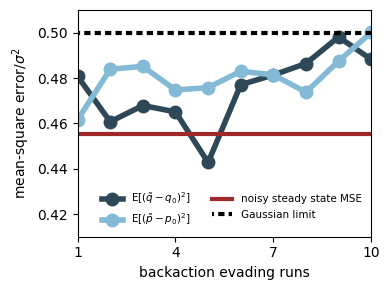

In [37]:
name = 'data-figure-noisy-backaction-performance'
dict_figure = np.load(path_QS_figures_data+name+'.npz',allow_pickle=True)
MSE_q = dict_figure['MSE_q']
MSE_p = dict_figure['MSE_p']
sigma = dict_figure['sigma']
N = dict_figure['N']
repeat = dict_figure['repeat']
ideal_noisy_MSE = dict_figure['ideal_noisy_MSE']


fig, ax = plt.subplots(1,1,figsize=(4,3))
x_range = np.arange(1,N+1)

shine = 1.0
# ax.plot(x_range,mean_means_MSE_q_Trange[i]*np.ones(len(x_range)),color=lighten_color(dark_blue,shine),lw=2,label=None,ls=(1,(1,1)))
# ax.plot(x_range,mean_means_MSE_p_Trange[i]*np.ones(len(x_range)),color=lighten_color(light_blue,shine),lw=2,label=None,ls=(1,(1,1)))
ax.plot(x_range,MSE_q/sigma**2,color=lighten_color(dark_blue,shine),lw=4,label=r'E$[(\tilde q-q_0)^2]$',marker='o',markersize=9)
ax.plot(x_range,MSE_p/sigma**2,color=lighten_color(light_blue,shine),lw=4,label=r'E$[(\tilde p-p_0)^2]$',marker='o',markersize=9)
ax.plot(x_range,ideal_noisy_MSE*np.ones(len(x_range)),color=lighten_color(red,1),lw=3,label=r'noisy steady state MSE'.format(6))
ax.plot([1,31],[.5,.5],color='black',ls=(1,(1.5,1)),lw=3,label=r'Gaussian limit')

ax.set_xticks([1,4,7,10])
ax.set_yticks([.42,.44,.46,.48,.5])
ax.set_xlabel(r'backaction evading runs',fontsize=10)
ax.set_ylabel(r'mean-square error$/\sigma^2$',fontsize=10)

ax.set_ylim(0.41,.51)
ax.set_xlim(1,10)
ax.legend(loc='lower right',fontsize=7.5,ncol=2,framealpha=0)
plt.tight_layout()
name = 'appendix-fig18-BA-noisy-performance'
fig.savefig(path_QS_figures+name+'.pdf',bbox_inches='tight',dpi=1000)
plt.show()